# Comparison of reservation_price between SEATTLE and BOSTON

# Introduction

This topic is my practices on the [Learning path of Udacity](https://classroom.udacity.com/nanodegrees/nd025-ent/parts/d52fd59b-fa33-4cd0-8d96-11e461669484/modules/07d3f5fa-3026-4414-b7a6-b0de6c628aea/lessons/2dac695b-c799-46b4-9b3b-c6ff460dbbf3/concepts/d0f0c9ed-424d-4360-aa59-811b52c54304)

The source dataset is taken from [Seattle Airbnb](https://www.kaggle.com/airbnb/seattle) and [Boston Airbnb](https://www.kaggle.com/airbnb/boston)

According to the requirement `"pose at least three questions related to business or real-world applications of how the data could be used"` of Udacity, I had figured out 5 questions in this topic

>- 1) Try to understand how much AirBNB homes are earning in certain time frames and areas/ cities.

>- 2) Examine the Total_price by top20 listing_id at each city and its reservation days.

>- 3) Try to understand if there is anything about the properties that helps you predict price, based on the 2 datasets: boston_listings and seattle_listings.

>- 4) Can you find negative and positive reviews based on text?

>- 5) Make 2 time-series model to forecasting the difference of the reservation_prices between 2 cities.

Follow that, we can understand the difference between 2 cities by looking at these question, doing EDA and also comparing the Machine Learning models. Moreover, these 5 questions is applied many problems:

>- Time-series forecasting in Question 5

>- Regression in Question 3

>- Ngrams-analytics (a part of NLP) in Question 4.

Name: Do Van Nhan

Account: NhanDV6

Now, we must import the necessary libraries then load our dataset

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sea_calendar = pd.read_csv("../input/compare/seattle_calendar.csv")
bos_calendar = pd.read_csv("../input/compare/boston_calendar.csv")
sea_reviews = pd.read_csv("../input/compare/seattle_reviews.csv")
bos_reviews = pd.read_csv("../input/compare/boston_reviews.csv")
sea_listings = pd.read_csv("../input/compare/seattle_listings.csv")
bos_listings = pd.read_csv("../input/compare/boston_listings.csv")

# EDA

## Viewing size of dataset

##### Figure out our dataset: Number of columns, number of rows and memory usages

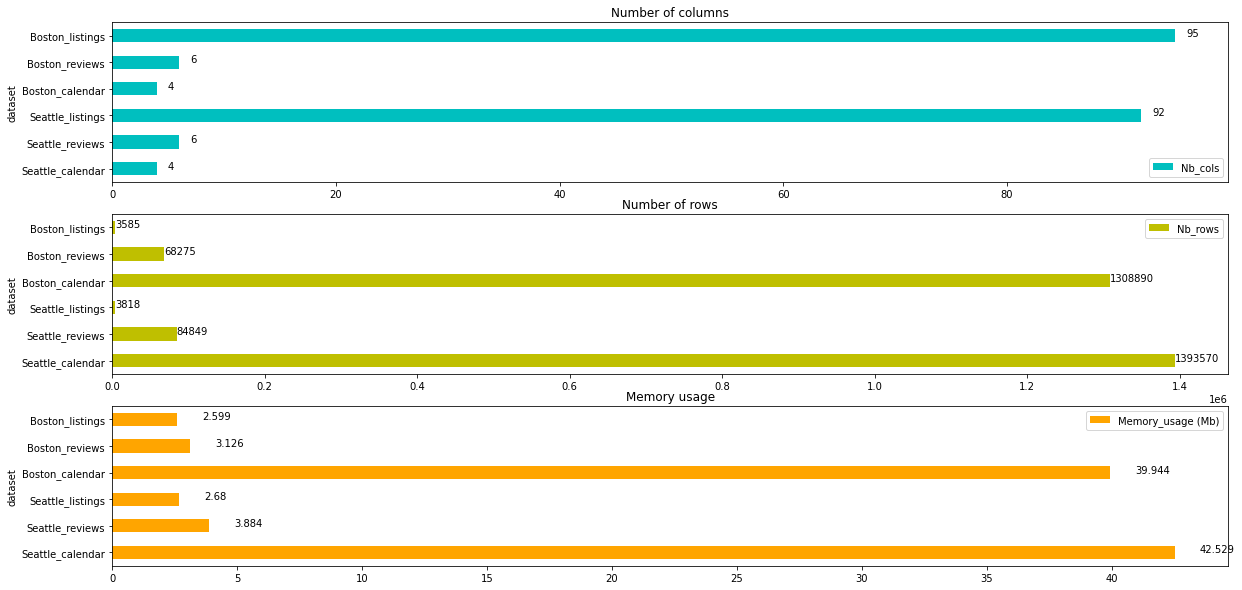

In [2]:
dfs = [sea_calendar, sea_reviews, sea_listings, bos_calendar, bos_reviews, bos_listings]
subtit = ['Number of columns', 'Number of rows', 'Memory usage']
df = pd.DataFrame({'Nb_cols': [df.shape[1] for df in dfs],
                   'Nb_rows': [df.shape[0] for df in dfs],
                   'Memory_usage (Mb)' : [round(df.memory_usage().sum() / 1024**2, 3) for df in dfs],
                   'dataset': ['Seattle_calendar', 'Seattle_reviews', 'Seattle_listings', 
                           'Boston_calendar', 'Boston_reviews', 'Boston_listings']
             })

# Visualize
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (20, 10))
for k, c in enumerate(['c', 'y', 'orange']):
    df.plot(x = 'dataset', title = subtit[k], y = list(df.columns)[k], kind = 'barh', color = c, ax = ax[k])
    for p in ax[k].patches:
        ax[k].annotate(str(p.get_width()), (p.get_width() + 1, p.get_y()+p.get_height() - 0.25))
plt.show()

## 1. Looking at the missing values

In [3]:
def countNA_merge_cities(boston_df, seattle_df):
    """
    Description: this function is used to compute the number of mising values in the input datasets
    Input:
            dataset 1
            dataset 2
    Output:
            The datasets has 3 columns
                    columns: column_names
                    isnull_Boston: number of missing values of a columns in Boston dataset
                    isnull_Seattle: number of missing values of a columns in Seattle dataset
    """
    merge_df = pd.DataFrame({'columns': list(seattle_df.columns),
                            'isnull_Boston': boston_df.isnull().sum().values,
                            'isnull_Seattle': seattle_df.isnull().sum().values
                           })
    return merge_df

def percentage_NA_merge_cities(boston_df, seattle_df):
    
    """
    Description: this function is used to compute the percentage of mising values in the input datasets
    Input:
            dataset 1
            dataset 2
    Output:
            The datasets has 3 columns
                    columns: column_names
                    isnull_Boston: percentage of missing values of a columns in Boston dataset
                    isnull_Seattle: percentage of missing values of a columns in Seattle dataset
    """
    
    merge_df = pd.DataFrame({'columns': list(seattle_df.columns),
                            'isnull_Boston': 100*boston_df.isnull().sum().values / len(boston_df),
                            'isnull_Seattle': 100*seattle_df.isnull().sum().values / len(seattle_df)
                           }).round(2)
    return merge_df

The first 2 groups `calendar` and `reviews` in 2 cities `Boston` and `Seattle` has the same schemas.

>> In the `calendar_df: Boston and Seattle`, they have the same 4 columns: `price`, `available`, `date` and `listing_id`

>> In the `review_df: Boston and Seattle`, they have the same 5 columns: `comments`, `reviewer_name`, `reviewer_id`, `id` and `listing_id`.

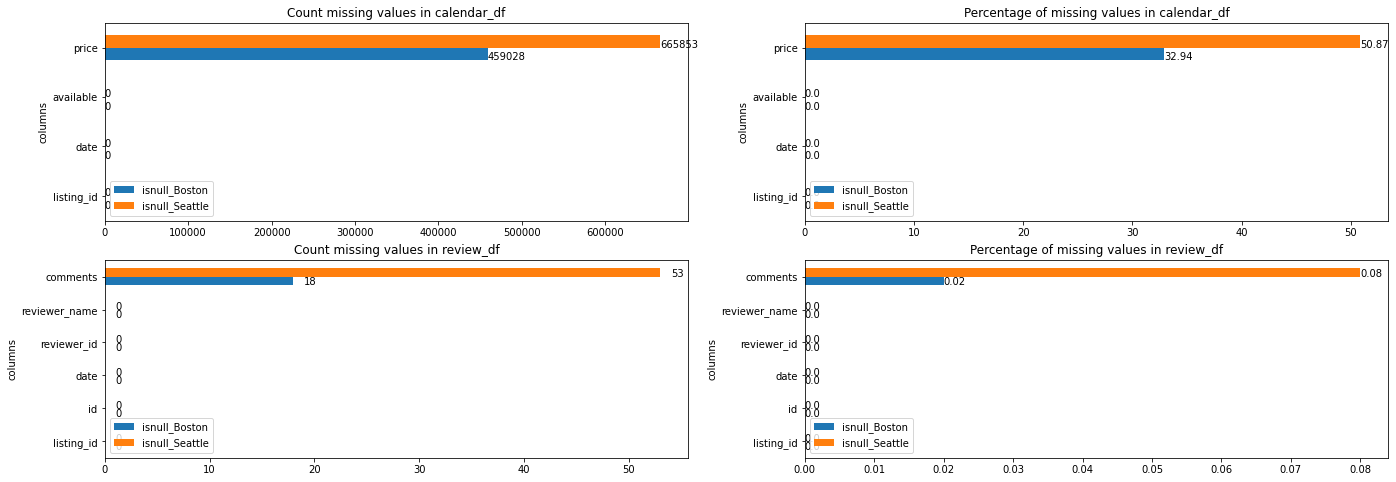

In [4]:
seattle_df = [sea_calendar, sea_reviews]
boston_df = [bos_calendar, bos_reviews]
sub_title = ['calendar_df', 'review_df']
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (23, 8))
ax = ax.ravel()
for k in range(2):
    calendar_df = countNA_merge_cities(seattle_df[k], boston_df[k])
    calendar_pr = percentage_NA_merge_cities(seattle_df[k], boston_df[k])
    calendar_df.plot(x = 'columns', kind = 'barh', ax = ax[2*k], title = 'Count missing values in {}'.format(sub_title[k]))
    for p in ax[2*k].patches:
        ax[2*k].annotate(int(p.get_width()), (p.get_width() + 1, p.get_y()+p.get_height() - 0.25))
    calendar_pr.plot(x = 'columns', kind = 'barh', ax = ax[2*k + 1], title = 'Percentage of missing values in {}'.format(sub_title[k]))
    for p in ax[2*k+1].patches:
        ax[2*k+1].annotate(str(p.get_width()), (p.get_width(), p.get_y()+p.get_height() - 0.25))
plt.show()

#### Commnent 1. The number of missing values in `Seattle_df` is higher than in `Boston_df`

### How about the group `listing`

There are many columns have too much missing values in the listing dataframes, noting that these datasets has only 3585 and 3884 rows, considered `Boston_listings` and `Seattle_listings` respectively.

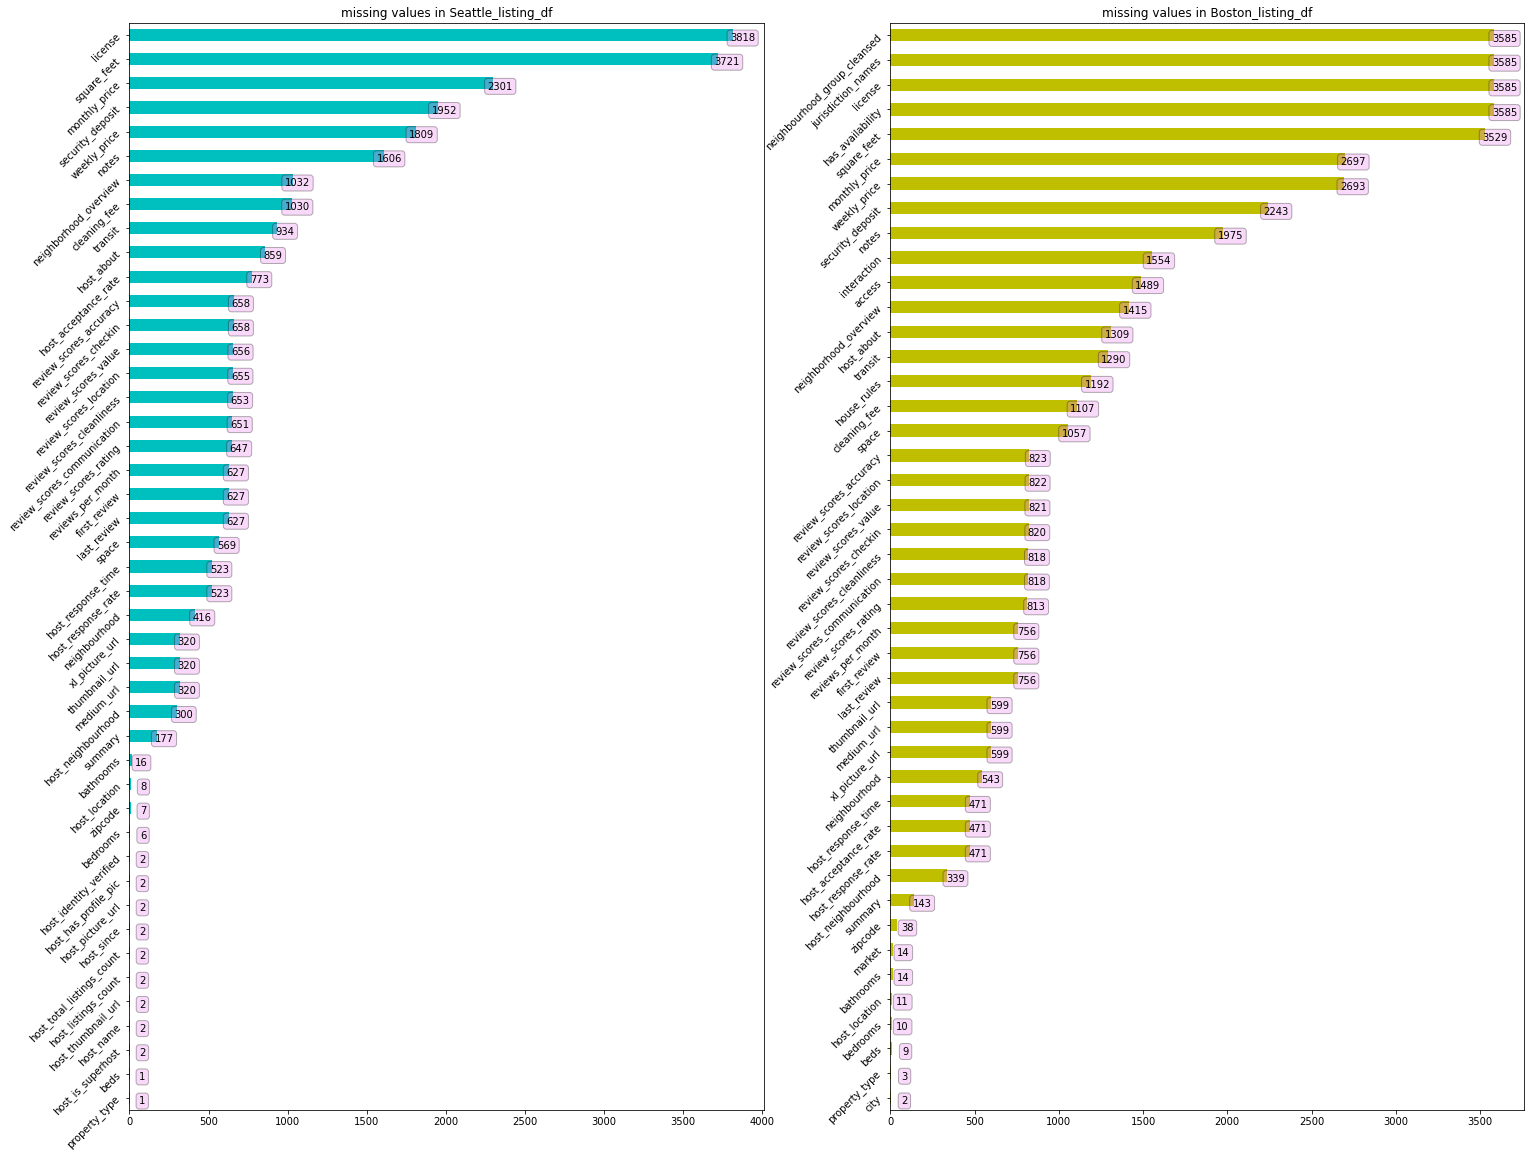

In [5]:
group_list = [sea_listings, bos_listings]; colors = ['c', 'y']
titles = ['missing values in Seattle_listing_df', 'missing values in Boston_listing_df']
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 20))
for k in range(2):
    count_null = group_list[k].isnull().sum().sort_values(ascending = True)
    real_null = count_null[count_null > 0]
    real_null.plot(title = titles[k], kind = 'barh', color = colors[k], rot = 45, ax = ax[k])
    for p in ax[k].patches:
        ax[k].annotate(str(p.get_width()), (p.get_width() * 1.01 + 100, p.get_y()+p.get_height() - 0.5), color = 'black',
                             bbox = dict(boxstyle = 'round,pad=0.3', fc = 'violet', alpha=0.3), horizontalalignment='right')
plt.show()

## 2. Cleaning & Merging dataset to compare
#### For `reviews_group`
First, viewing our dataset!

Look at the output below, the column `date` is denoted `object` while we expected its type must be `datetime`!!!

In [6]:
print("Seattle_reviews.csv", sea_reviews.dtypes, sea_reviews['date'].max(), sea_reviews['date'].min())
print("Boston_reviews.csv", bos_reviews.dtypes, bos_reviews['date'].max(), bos_reviews['date'].min())
sea_reviews.head(3)

Seattle_reviews.csv listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object 2016-01-03 2009-06-07
Boston_reviews.csv listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object 2016-09-06 2009-03-21


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."


So we must 
- convert the type in column `date` to `datetime`
- don't change anything in the other columns

In [7]:
def date_trsfr_reviews_df(df):
    df['date'] = pd.to_datetime(df['date'])
    
    return df
reviews_df = date_trsfr_reviews_df(sea_reviews)
reviews_df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


After cleaning the `reviews datasets`, then now is the time for viewing what we have in the `calendar dataframes`?

In [8]:
print(sea_calendar.available.value_counts())
sea_calendar.head(2)

t    934542
f    459028
Name: available, dtype: int64


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


The columns `available` has 2 values is `t` (for `True`) and `f` (for `False`)

#### For the calendar_group: 
>- Remove the `$` and `,` in `price` then convert the values to `float`
>- Replace `t, f` in `available` to `True` and `False`

In [9]:
sea_calendar['city'] = 'seattle'
bos_calendar['city'] = 'boston'

def clean_price(df):
    """
    Description: this function is used to clean your dataset
    Input : dataframe
    Output : dataframe has corrected datetime; corrected price in float and replaced the object-type (t, f) by boolean-type (True, False)
    """
    df = df.dropna()
    df['date'] = pd.to_datetime(df['date'])    
    df['price'] = df.price.apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)
    df['available'] = df['available'].replace({'t': True, 'f': False})
    
    return df
sea_calendar = clean_price(sea_calendar)
bos_calendar = clean_price(bos_calendar)
calendar_df = pd.concat([bos_calendar, sea_calendar])
calendar_df.head()

,listing_id,date,available,price,city
365,3075044,2017-08-22,True,65.0,boston
366,3075044,2017-08-21,True,65.0,boston
367,3075044,2017-08-20,True,65.0,boston
368,3075044,2017-08-19,True,75.0,boston
369,3075044,2017-08-18,True,75.0,boston


Finnaly, is cleaning the dataset of `listing_group`, this will take a lots of things to do

#### For the `listing_group`
We must do step-by-step the following tasks:

>- Cleaning the values in the price columns
>- Filling the missing values of columns by using its averages or mode? 
>- Decided which columns to drop or keep!

In [10]:
def get_extra_people_fee(ser):  
    
    """
    Description: This function is used to compute the extra people in a column / serie
    Input: Column / serie
    Output: return the extra people based on examining the price is equal to 0 or not?
    """
    
    if ser['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0
    
def clean_listing_df(df):
    
    """
    Description: This function is used to clean the dataset of listing
    Input: dataset
    Output: Cleaned dataset by filling missing_values with the average values or mode of each column.
    """
    
    df['price'] = df.price.apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    df['property_type'] = df['property_type'].fillna(df['property_type'].mode()[0])
    
    df['extra_people_fee'] = df.apply(lambda x: get_extra_people_fee(x),axis=1)
    fill_avg_columns = ['host_listings_count', 'square_feet',
                        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in fill_avg_columns:
        df[column].fillna(df[column].mean(), inplace = True)
    
    return df

sea_listings = clean_listing_df(sea_listings)
bos_listings = clean_listing_df(bos_listings)

# Answers question on Udacity
Pose at least three questions related to business or real-world applications of how the data could be used.
# Q.1. Try to understand how much `AirBNB` homes are earning in certain `time frames` and `areas/ cities`.
>- The daily average price between 2 cities.

>>> Look at the following code and its result, we can see that "the average price in Seattle is lower than in Boston", but the total_revenue at Seattle is nearly approximate at in Boston. The second chart show that there are more reservations in Seattle than in Boston

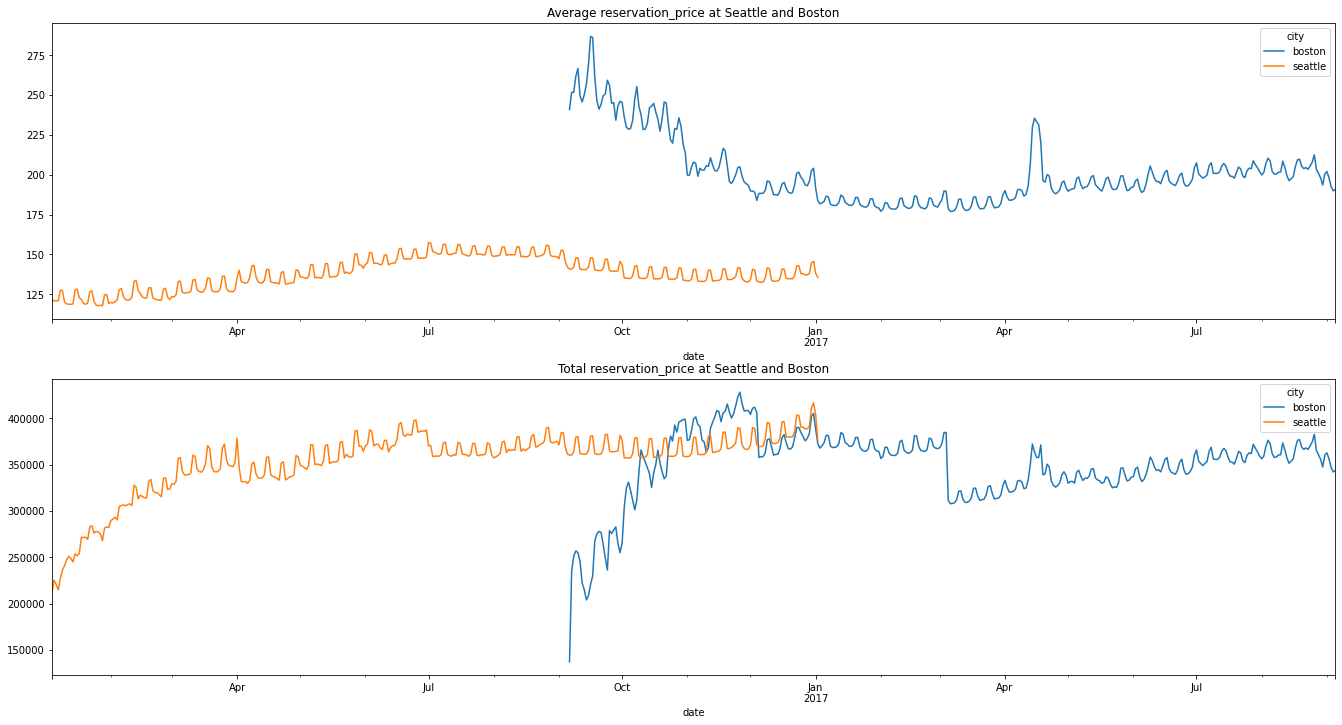

In [11]:
calendar_df_avg_daily = calendar_df.groupby(['date', 'city']).mean()[['price']].reset_index()
calendar_df_avg_daily = pd.pivot(calendar_df_avg_daily, values = 'price', index = ['date'], columns = 'city')

calendar_df_sum_daily = calendar_df.groupby(['date', 'city']).sum()[['price']].reset_index()
calendar_df_sum_daily = pd.pivot(calendar_df_sum_daily, values = 'price', index = ['date'], columns = 'city')

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (23, 12))
calendar_df_avg_daily.plot(title = 'Average reservation_price at Seattle and Boston', ax= ax[0])
calendar_df_sum_daily.plot(title = 'Total reservation_price at Seattle and Boston', ax= ax[1])
plt.show()

Moreover, look at the `average_price`, we have seen that the listing prices raise significantly in summer at `Seattle` and in autumn at Boston, probably, because of the fact that there are less listings available for reservation. There is also a raise in December at `Seattle` and in May at `Boston`. This tells us that summer and winter holidays should be the busiest times to visit `Seattle`, also autumn to visit `Boston`.

- So which certained time that the time-series attain highest and lowest in each charts? 

>> The `avg_price` is lowest in `01, Apr 2016` at `Seattle` and in `06 Sep 2016` at `Boston`

>> The `avg_price` is highest in `02, Jan 2017` at `Seattle` and in `05 Sep 2017` at `Boston`

In [12]:
pd.concat([calendar_df_avg_daily['boston'].dropna().reset_index().agg(['min', 'max']), 
           calendar_df_avg_daily['seattle'].dropna().reset_index().agg(['min', 'max'])])

,date,boston,seattle
min,2016-09-06,177.023002,NaN
max,2017-09-05,286.921977,NaN
min,2016-01-04,NaN,117.685413
max,2017-01-02,NaN,157.480000


The highest and lowest total prices per day at each city is the same with its average values

In [13]:
pd.concat([calendar_df_sum_daily['boston'].dropna().reset_index().agg(['min', 'max']), 
           calendar_df_sum_daily['seattle'].dropna().reset_index().agg(['min', 'max'])])

,date,boston,seattle
min,2016-09-06,137395.0,NaN
max,2017-09-05,428100.0,NaN
min,2016-01-04,NaN,211819.0
max,2017-01-02,NaN,416551.0


>- The monthly average price between 2 cities.

The diagrams below shows us the prices depending on month. These graphs will demonstrate more detail than in the graph of `average_price per day`

>> At `Boston`, Jan2017 - Mar2017 is the time that the average price is lowest

>> At `Seattle`, Jan2016 - Mar2016 is the time that the average price is lowest

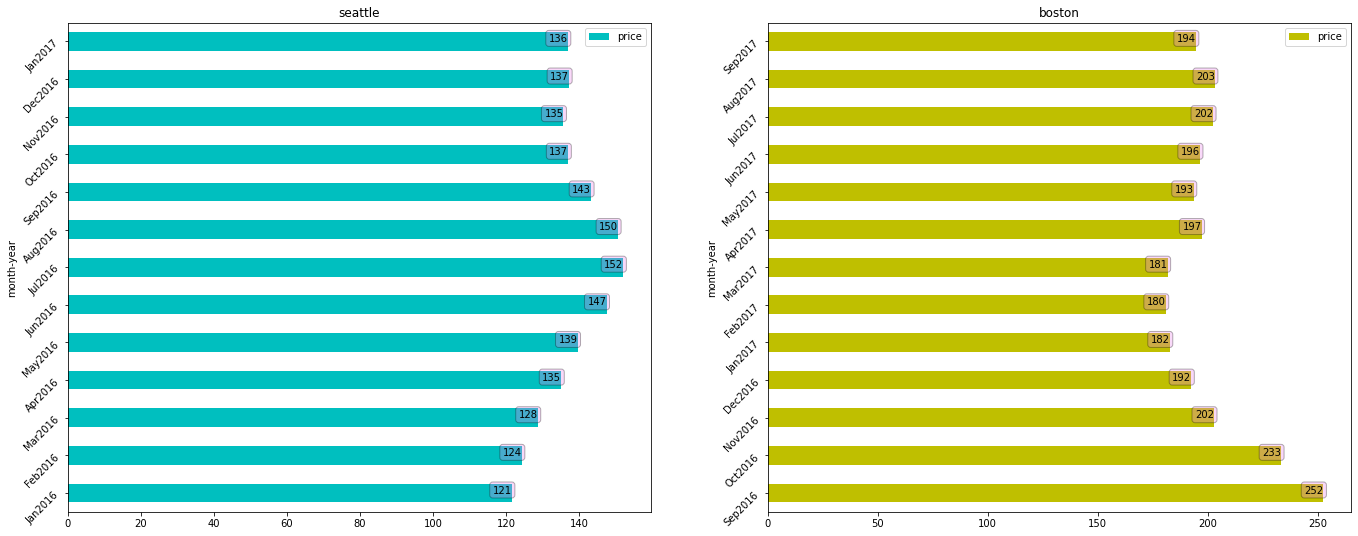

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (23, 9))
for idx, city in enumerate(['seattle', 'boston']):
    city_calendar_df = calendar_df[calendar_df.city == city].set_index('date').resample('M').mean()[['price']].reset_index()
    city_calendar_df['month-year'] = city_calendar_df['date'].dt.month_name().apply(lambda x: str(x)[:3]) + city_calendar_df['date'].dt.year.apply(lambda x: str(x))
    city_calendar_df.plot(x = 'month-year', color = colors[idx], y = 'price', kind = 'barh', rot = 45, ax = ax[idx], title = city)
    for p in ax[idx].patches:
        ax[idx].annotate(int(p.get_width()), (p.get_width(), p.get_y()+p.get_height()/2),color = 'black',
                             bbox = dict(boxstyle = 'round,pad=0.3', fc = 'violet', alpha=0.3)
                         , horizontalalignment='right'
                        )

>- Quarterly observed.

>> `1st quarter` is the quarter that the average prices is lowest in both `Seattle` (125 at `Q1-2016` and `136` at `Q1-2017`) and `Boston` (181 at `Q1-2017`).

>> `3rd quarter` is the quarter that the average prices is highest in both `Seattle` (148 at `Q3-2016`) and `Boston` (252 at `Q1-2017`).

>> Again, the quarterly_average_price in `Seattle` is lower than in `Boston`

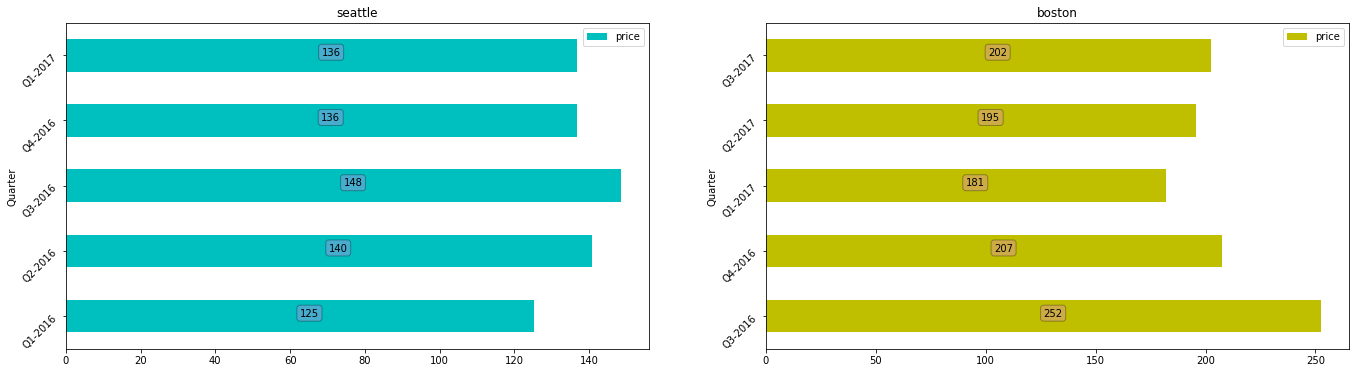

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (23, 6))
for idx, city in enumerate(['seattle', 'boston']):
    city_calendar_df = calendar_df[calendar_df.city == city].set_index('date').resample('Q').mean()[['price']].reset_index()
    city_calendar_df['Quarter'] = 'Q' + city_calendar_df['date'].dt.quarter.apply(lambda x: str(x)) + '-' + city_calendar_df['date'].dt.year.apply(lambda x: str(x))
    city_calendar_df.plot(x = 'Quarter', color = colors[idx], y = 'price', kind = 'barh', rot = 45, ax = ax[idx], title = city)
    for p in ax[idx].patches:
        ax[idx].annotate(int(p.get_width()), (p.get_width() / 2, p.get_y()+p.get_height() / 2),color = 'black',
                             bbox = dict(boxstyle = 'round,pad=0.3', fc = 'violet', alpha=0.3))

# Q2. Examine the Total_price by top20 listing_id at each city and its reservation days

Top 20 listing_id in `Seattle` has the longer reservation days but the total_price is lower than in `Boston`

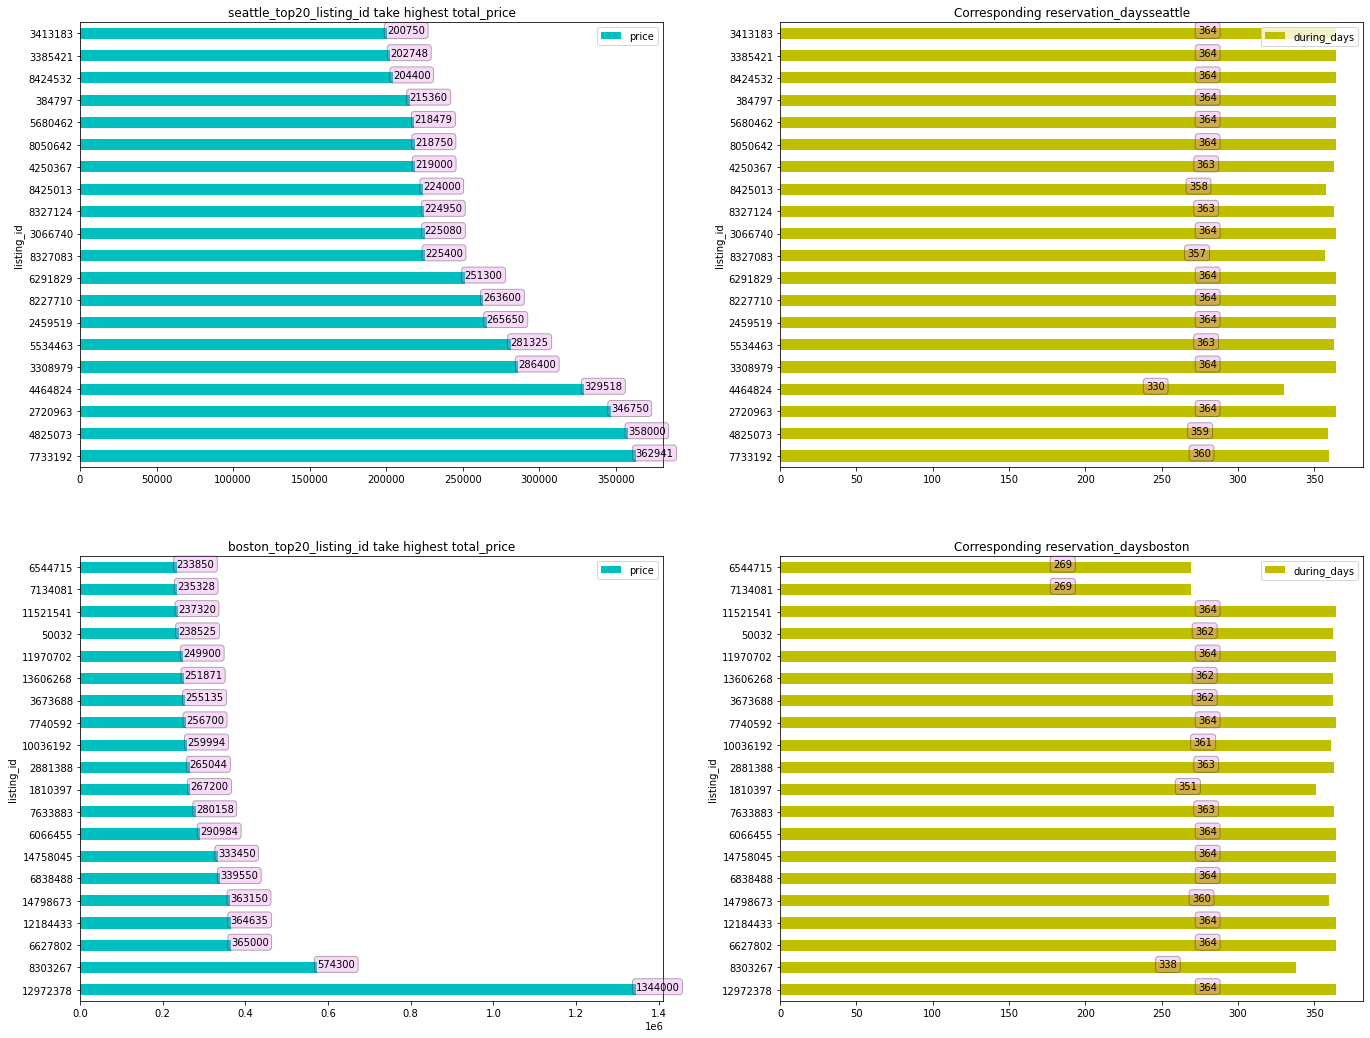

In [16]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (23, 18))
ax = ax.ravel()
for idx, city in enumerate(['seattle', 'boston']):
    df = calendar_df.groupby(['city', 'listing_id']).sum()[['price']].reset_index()
    df = df[df.city == city].sort_values(by = 'price', ascending = False)[:20]
    list_id = df.listing_id
    df2 = calendar_df[calendar_df.listing_id.isin(list_id)][['date', 'listing_id' ,'price']]
    x = df2.groupby('listing_id').max()[['date']] - df2.groupby('listing_id').min()[['date']]
    df['during_days'] = (x.astype('timedelta64[h]')//24).astype(float).values.ravel()

    df.plot(x = 'listing_id', y = 'price', kind = 'barh', color = 'c', title = city + '_top20_listing_id take highest total_price', ax = ax[2*idx])
    for p in ax[2*idx].patches:
        ax[2*idx].annotate(int(p.get_width()), (p.get_width(), p.get_y()+p.get_height() / 2),color = 'black',
                             bbox = dict(boxstyle = 'round,pad=0.3', fc = 'violet', alpha=0.3))    
        
    df[['listing_id', 'during_days']].plot(x = 'listing_id', y = 'during_days', kind = 'barh', color = 'y', 
                                           title =  'Corresponding reservation_days' + city, ax = ax[2*idx + 1])
    for p in ax[2*idx + 1].patches:
        ax[2*idx + 1].annotate(int(p.get_width()), (p.get_width() - 90 , p.get_y() + p.get_height() / 2), 
                               bbox = dict(boxstyle = 'round,pad=0.3', fc = 'violet', alpha=0.3) ) 

And how about the `average_price` by `Number of listing_id`?

>> The majority of listings is concentrated around `50 - 150 USD` in `Seattle` and about `50-250 $` in `Boston`

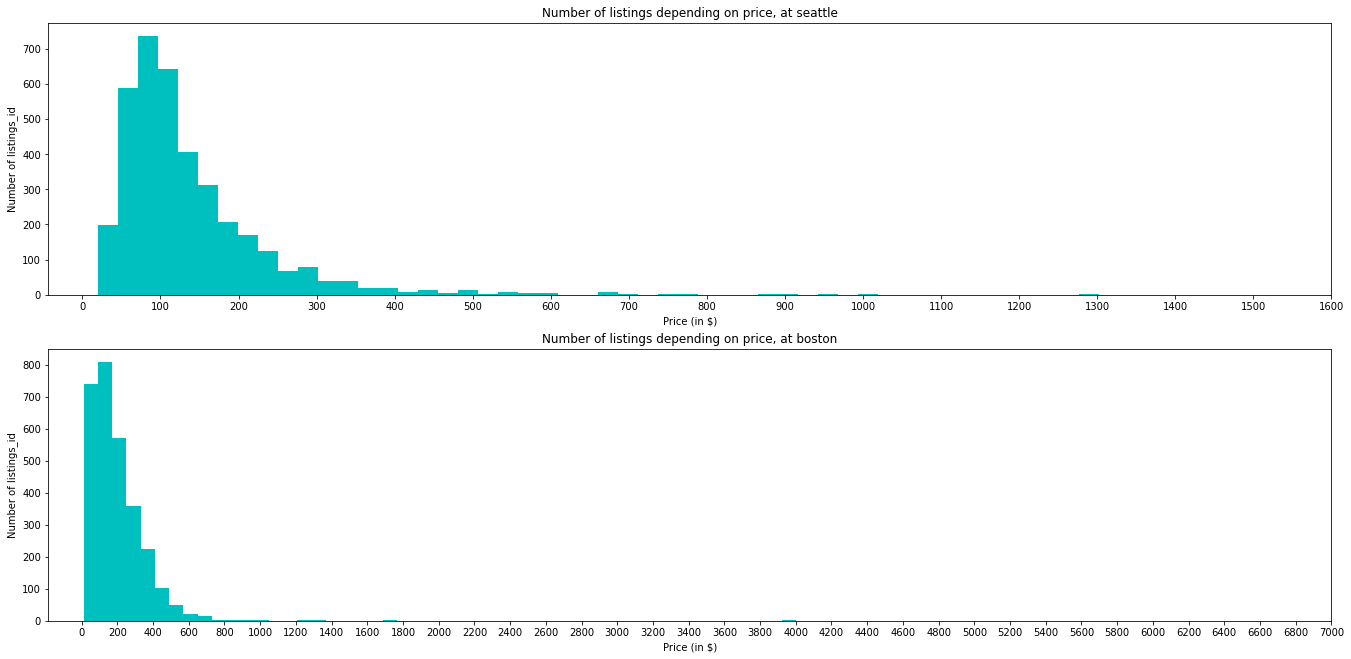

In [17]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (23, 11))
for idx, city in enumerate(['seattle', 'boston']):
    df = calendar_df[calendar_df.city == city]
    mean_price_for_listing = df.groupby('listing_id').mean()['price']
    ax[idx].hist(mean_price_for_listing, color = 'c', bins = 50)
    ax[idx].set_xticks(np.arange(0, df['price'].max(), step = 100 * (1 + idx)))
    ax[idx].set_ylabel('Number of listings_id')
    ax[idx].set_xlabel('Price (in $)')
    ax[idx].set_title('Number of listings depending on price, at ' + city)

# Q3. Try to understand if there is anything about the properties that helps you predict price, based on the 2 datasets: `boston_listings` and `seattle_listings`.
First, we must examine the common-features between this 2 dataset: `boston_listings` and `seattle_listings`

In [18]:
bos_cols_ls = sorted(list(bos_listings.columns))
sea_cols_ls = sorted(list(sea_listings.columns))
same = set(bos_cols_ls).intersection(set(sea_cols_ls))
print(sorted(list(same)))
len(list(same))

['accommodates', 'amenities', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'bathrooms', 'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calendar_last_scraped', 'calendar_updated', 'cancellation_policy', 'city', 'cleaning_fee', 'country', 'country_code', 'description', 'experiences_offered', 'extra_people', 'extra_people_fee', 'first_review', 'guests_included', 'has_availability', 'host_about', 'host_acceptance_rate', 'host_has_profile_pic', 'host_id', 'host_identity_verified', 'host_is_superhost', 'host_listings_count', 'host_location', 'host_name', 'host_neighbourhood', 'host_picture_url', 'host_response_rate', 'host_response_time', 'host_since', 'host_thumbnail_url', 'host_total_listings_count', 'host_url', 'host_verifications', 'id', 'instant_bookable', 'is_location_exact', 'jurisdiction_names', 'last_review', 'last_scraped', 'latitude', 'license', 'listing_url', 'longitude', 'market', 'maximum_nights', 'medium_url', 'minimum_nights

93

So, there are 93 columns in the intersection of these datasets, but we must remove all the features get too many missing values and also too many category values.

In [19]:
columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'has_availability', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                   'reviews_per_month']
same = set(same).difference(set(columns_to_drop))
print(sorted(list(same)))

['accommodates', 'amenities', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'bathrooms', 'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count', 'cancellation_policy', 'extra_people', 'extra_people_fee', 'guests_included', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'host_listings_count', 'host_response_rate', 'host_response_time', 'host_since', 'host_verifications', 'id', 'instant_bookable', 'maximum_nights', 'minimum_nights', 'neighbourhood_group_cleansed', 'number_of_reviews', 'price', 'property_type', 'require_guest_phone_verification', 'require_guest_profile_picture', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_rating', 'review_scores_value', 'room_type', 'smart_location', 'square_feet']


When forecasting the price of house, we have seen that these feature can be strongly affect to the price are 
>> Numeric features: `'bathrooms'`, `'beds'`, `'square_feet'`, `'availability_30'`, `'availability_365'`, `'availability_60'`, `'availability_90'`, `'number_of_reviews'`, `'accommodates'`, `'review_scores_rating'`, `review_scores_location'` and `'host_listings_count'`

>> Category features: `'bed_type'`, `'smart_location'`, `'property_type'`, `'room_type'` and may be `'neighbourhood_group_cleansed'`

In [20]:
numr_feat = sorted(['bathrooms', 'beds', 'square_feet', 'availability_30', 
                    'availability_365', 'availability_60', 'availability_90', 
                    'number_of_reviews', 'accommodates', 'review_scores_rating', 'extra_people_fee', 'price',
                    'review_scores_location', 'host_listings_count'])
cate_feat = ['bed_type', 'smart_location', 'property_type', 'room_type', 'neighbourhood_group_cleansed']

- Check again which features in the numeric_features can be influenced the prices

To solve this, I will use the heatmap on the correlation matrix.

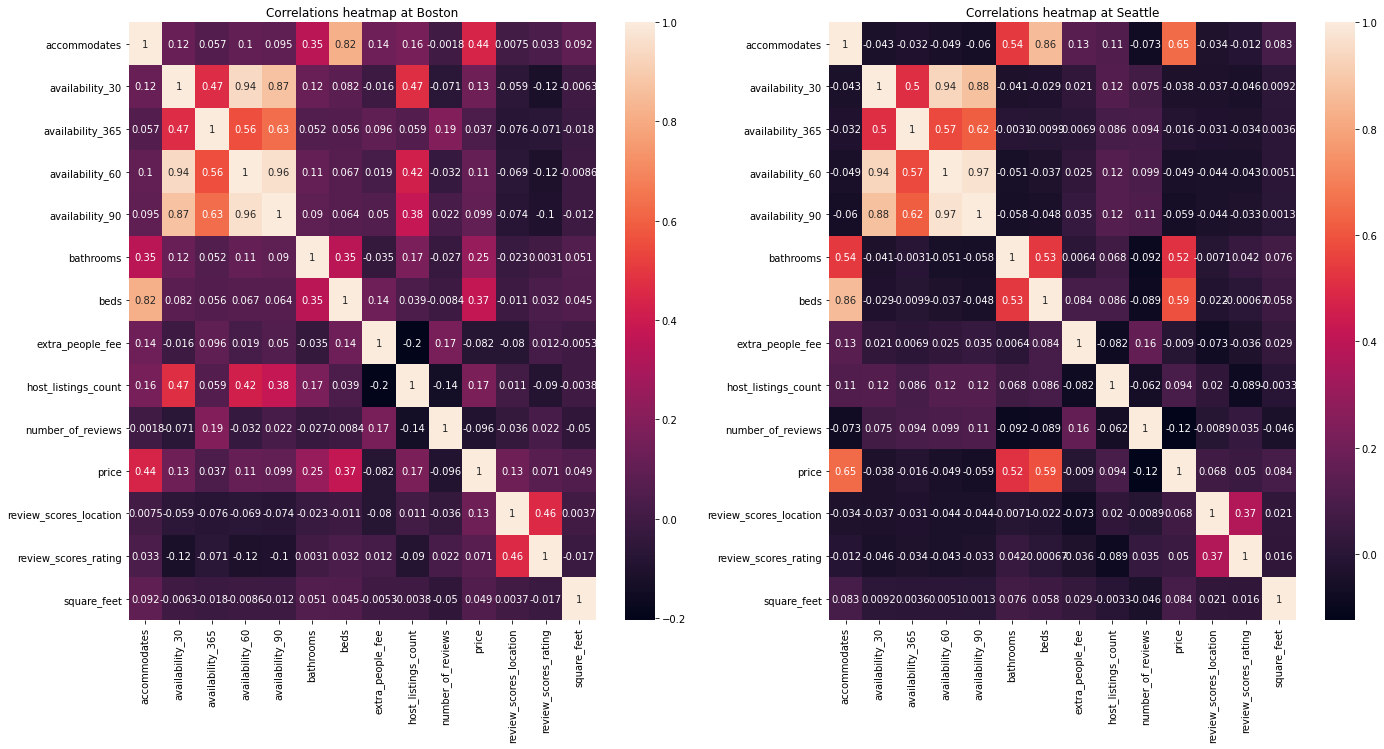

In [21]:
import seaborn as sns

bos_listings = bos_listings[same]
sea_listings = sea_listings[same]
dfs = [bos_listings, sea_listings]
cities = ['Boston', 'Seattle']
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (23, 11))
for idx, df in enumerate(dfs):
    corrs = df[numr_feat].corr()
    sns.heatmap(corrs, cbar = True, annot=True, ax = ax[idx])
    ax[idx].set_title('Correlations heatmap at ' + cities[idx])


So, 
>- At `Seattle`, the numeric features that strongly correlated to `price` be : `"accomodates"`: 0.67, `"beds"` : 0.59, and `"bathrooms`: 0.52; the other features is weakly-correlated to `price`.

>- At `Boston`, the numeric features that strongly correlated to `price` be : `"accomodates"`: 0.44, `"beds"` : 0.33, next be "bathrooms", "review_scores_rating" and "availability_30". The `"availability_30"` at `Boston` is about `0.13` shows that the reservation in this city is almost no longer than 1 month.

Now, how about the category features?

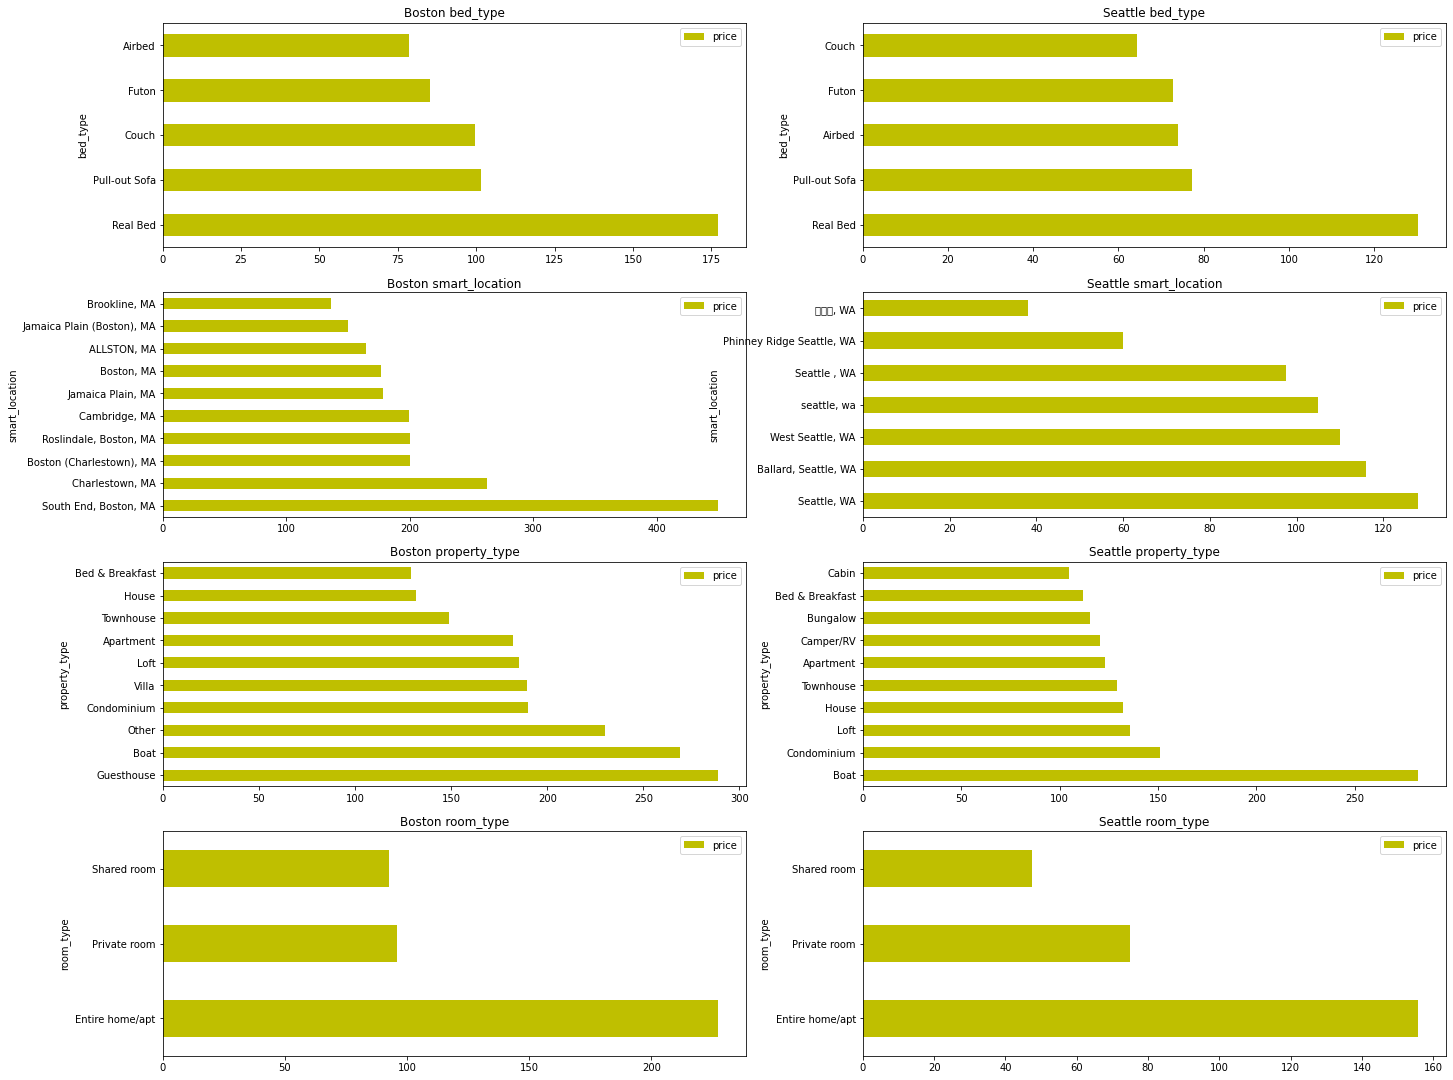

In [22]:
dfs = [bos_listings, sea_listings]
cities = ['Boston', 'Seattle']
fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (23, 19))
ax = ax.ravel()

for k in range(2):
    df = dfs[k][cate_feat]
    for q in range(len(cate_feat) - 1):
        z = dfs[k].groupby(cate_feat[q]).mean()[['price']]
        z.sort_values(by = 'price', ascending = False)[:10].reset_index().plot(x = cate_feat[q], 
                                                                          y = 'price', title = cities[k] + ' ' + cate_feat[q],
                                                                          color = 'y', kind = 'barh', ax = ax[q*2 + k])

This is easy to see that:

>> In the column `bed_type`, the value `Real_bed` has the highest average_price at both cities, while the `Airbed` is lowest in `Boston` and `Couch` is lowest in `Seattle`.

>> In the column `room_type`, the value `Entire home/apt` has the highest average_price at both cities, and obviously the `shared_room` is lowest.

>> In the column `property_type`, the value `Guesthouse` has the highest average_price in `Boston` while in `Seattle` is `Boat`, the lowest average_price in `Boston` is `Bed & breakfast` while `Cabin` is the lowest in `Seattle`.

**But, we must consider carefully the last features: `neighbourhood_group_cleansed`**

In `Boston` city, this feature totally contains the missing values, indeed;

In [23]:
pd.DataFrame(bos_listings[cate_feat].isnull().sum() / bos_listings.shape[0] * 100).rename(columns = {0: 'percentage of null'})

,percentage of null
bed_type,0.0
smart_location,0.0
property_type,0.0
room_type,0.0
neighbourhood_group_cleansed,100.0


Hence, we must drop the column `neighbourhood_group_cleansed`, but do you wonder how it affect to the average_price in `Seattle`? Look at the chart below!

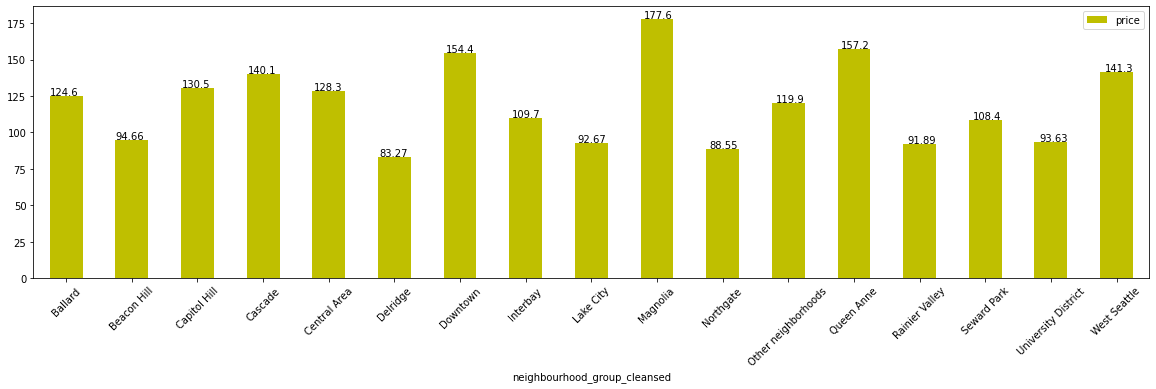

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 5))
sea_listings.groupby('neighbourhood_group_cleansed').mean()[['price']].plot(kind = 'bar', rot = 45, color = 'y', ax = ax)
for p in ax.patches:
    ax.annotate(str(p.get_height())[:5], (p.get_x() * 1.005, p.get_height() * 1.005))

On the diagram above (at `Seattle` city) we can see that prices differ depending on the location (neighbourhood). The highest average prices are in 3 areas: `Magnolia`, `Queen Anne` and `Downtown`; while the lowest is in `Delridge`, which is not surprising

#### predict price
Remind that we will drop the column `neighbourhood_group_cleansed`, we are able to apply `Machine learning methods` to see which features in dataset influence the price the most. In order to do this we will train two popular models (`Random Forest regressor [bagging]` and `Gradient Boosting regressor [boosting]`) based on decision trees and look at resulting feature importances.

In [25]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae

def mape(actual, predict):
    
    """
    Description: Compute the MAPE : mean absolute percentage of Error
    Input: 
            actual : actual values
            predict: forecasting values
    Output: return the MAPE defined by
                MAPE = mean(abs(actual - predict) / actual)
    """
    
    return np.mean(np.abs(actual - predict) / actual)

clfs = [RandomForestRegressor(n_estimators = 200, max_depth=9,
                               criterion = 'mse', 
                               random_state = 42, 
                               n_jobs=-1), 
        GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.05, subsample=0.8,
                                  max_depth=7)]
def display(df):
    
    """
    Descriptions: Display the charts of scoring_evaluate and top 10 features importance
    Input : df (dataframe)
    Output : show the charts of
            - MAPE and R2_score of the training and test set on 2 cities Boston and Seattle
            - MAE, RMSE, MSE of the training and test set on 2 cities Boston and Seattle
            - Top 10 features importance of the training and test set on 2 cities Boston and Seattle when using bagging (with Random Forest) and boosting (Gradient Boosting) models
    """
    
    methods = ['Random Forest', 'Gradient Boosting']
    cat_columns = list(df.select_dtypes(include=['object']).columns)
    df_cate = df[cat_columns]
    X = pd.concat([df[numr_feat], pd.get_dummies(df_cate, prefix_sep = '_is_', dummy_na=True,
                                                 drop_first = True)], axis = 1).drop(columns = 'price')
    y = df.price
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (25, 17.5), gridspec_kw={'height_ratios': [2, 3, 5]})
    ax = ax.ravel()
    for k, clf in enumerate(clfs):
        model = clf.fit(X_train, y_train)
        feature_importance = 100*model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        dat = pd.DataFrame({'index': list( x[:20]+'...' for x in X_train.columns[sorted_idx]),
                            'feature importance': feature_importance[sorted_idx]
                           })[-10:]
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)    

        # plot
        scor = pd.DataFrame({'score_names': ['MAPE', 'R2_score'],
                            'training': [mape(y_train, train_pred), r2_score(y_train, train_pred)],
                            'test_set': [mape(y_test, test_pred), r2_score(y_test, test_pred)]                        
                           }).set_index('score_names')
        scor.plot(ax = ax[k], kind = 'barh')
        err = pd.DataFrame({'score_names': ['MAE', 'MSE', 'RMSE'],
                            'training': [mae(y_train, train_pred), mse(y_train, train_pred), np.sqrt(mse(y_train, train_pred))],
                            'test_set': [mae(y_test, test_pred), mse(y_test, test_pred), np.sqrt(mse(y_test, test_pred))]                        
                           }).set_index('score_names').plot(ax = ax[k + 2], kind = 'barh')
        dat.set_index('index').plot(ax = ax[k + 4], rot = 45, title = 'Top10 feature importace using ' + methods[k], kind = 'barh')

> Forecasting in Seattle.

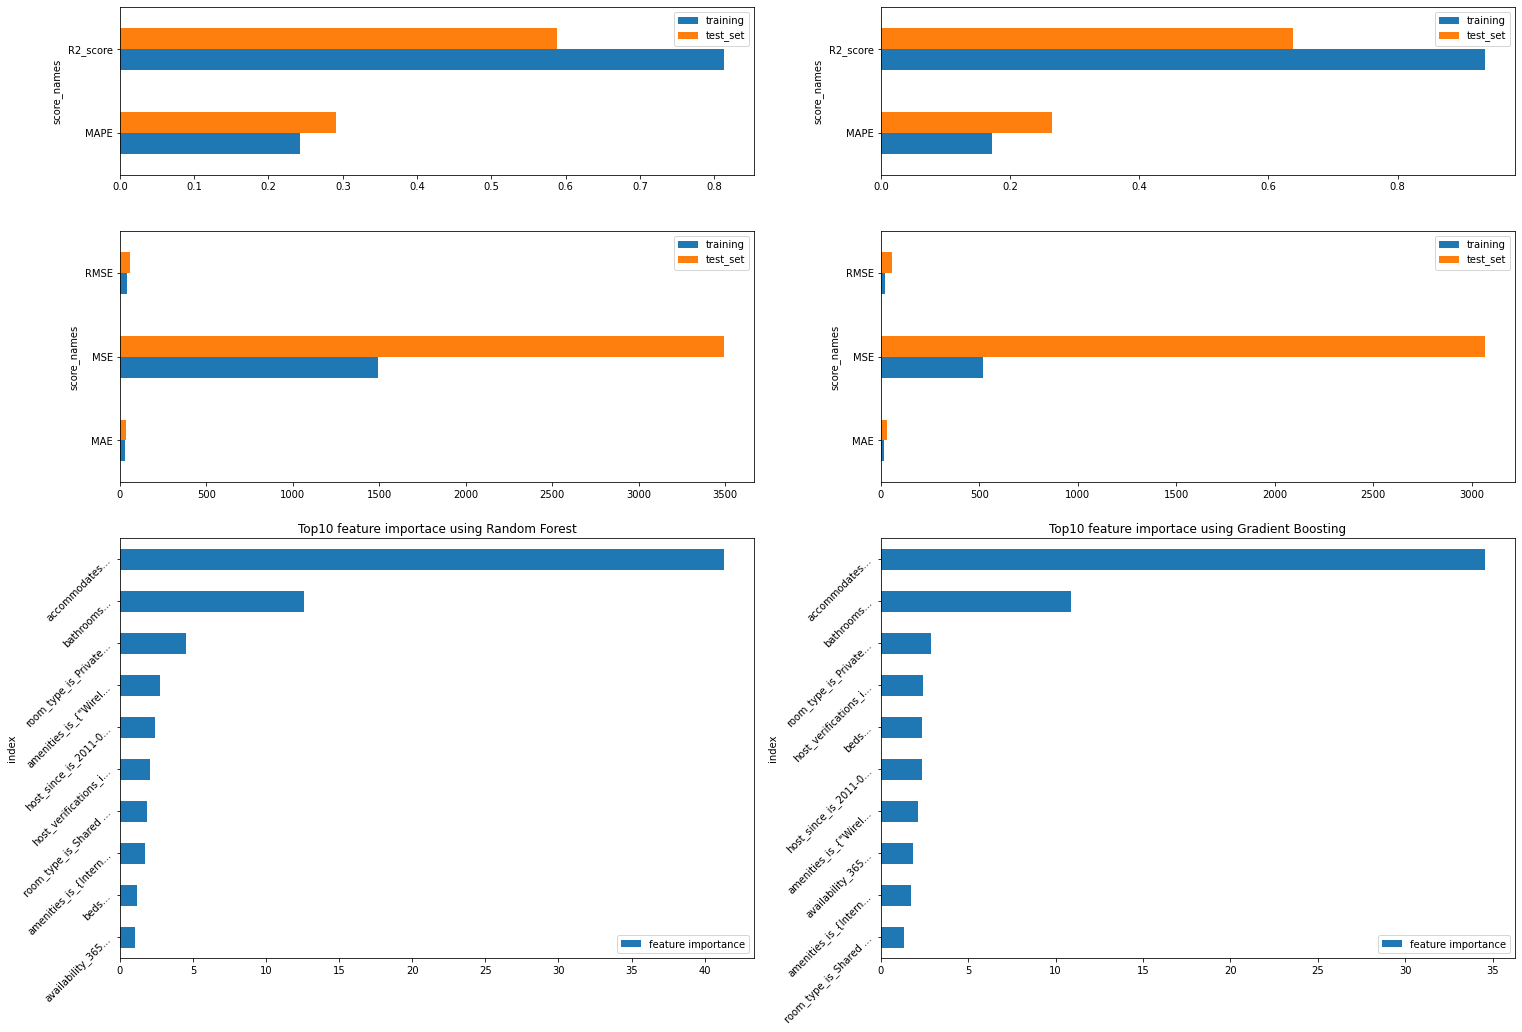

In [26]:
display(dfs[1])

>- And `Boston`

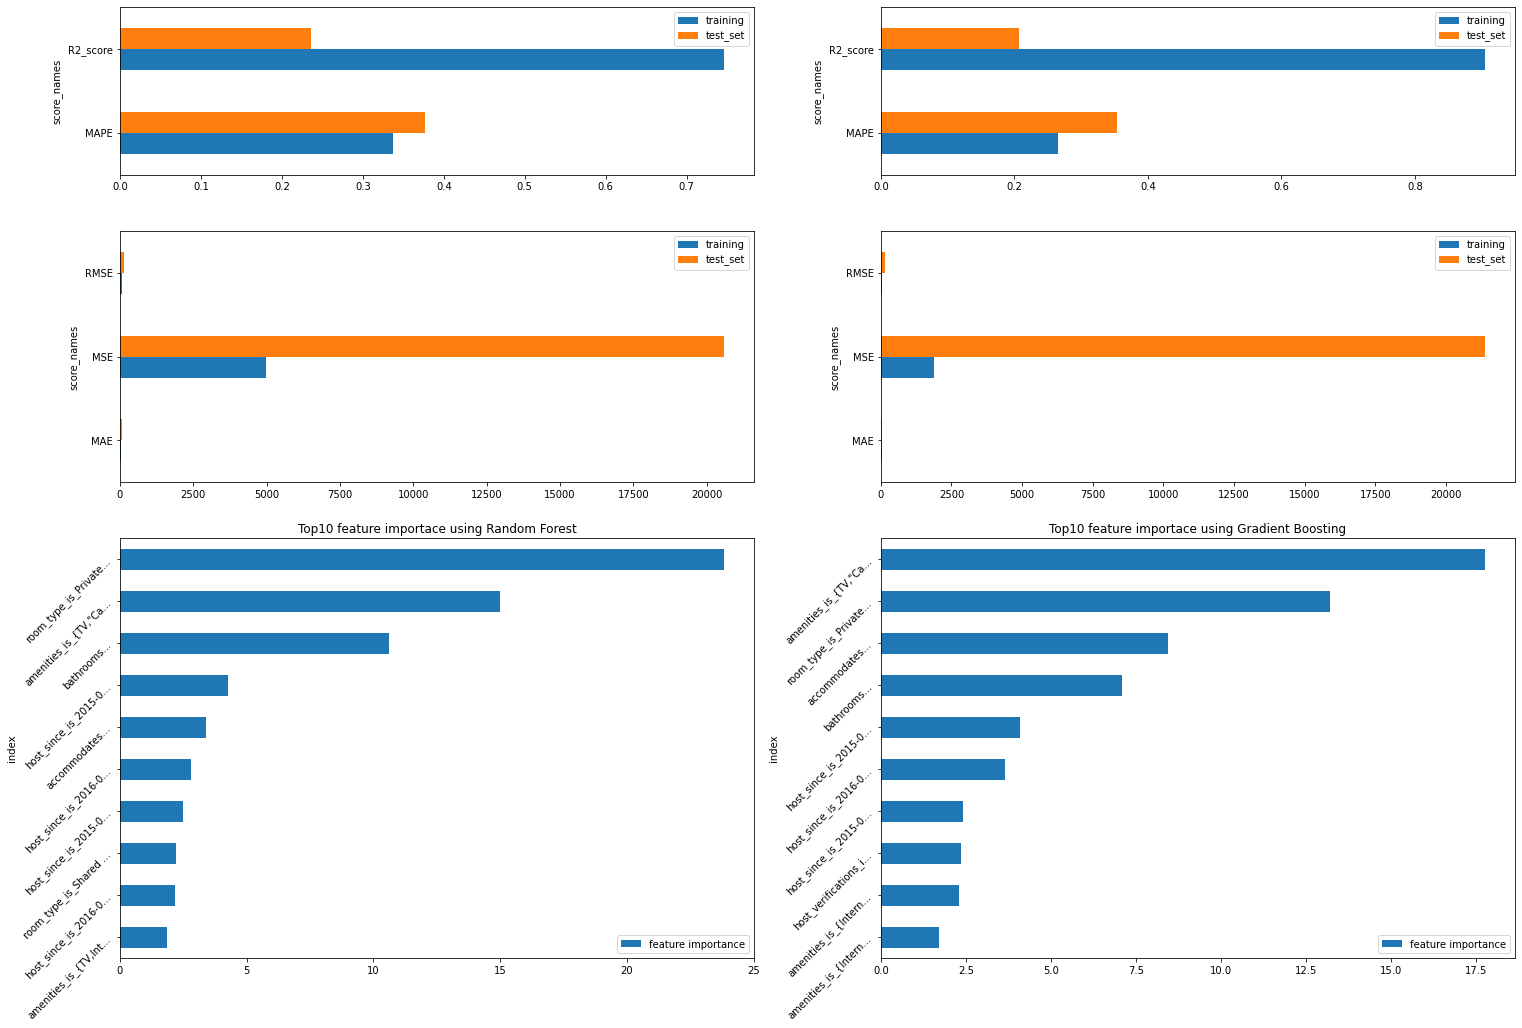

In [27]:
display(dfs[0])

#### Comments on Question 3.

These scores indicated that the model make `overfitting`, we must remove some features is not related / not correlated the price.

Moreover, to find the best `r2_score`, we can use grid_search CV / hyper-tuning parameters to solve this

# Q4. Can you find negative and positive reviews based on text?
Firstly, viewing each comment line by line is `impossible`

In [28]:
for k in range(10): 
    print(k, 29*'-')
    print('Seattle: \t' , sea_reviews.comments[k])
    print('Boston: \t', bos_reviews.comments[k])    

0 -----------------------------
Seattle: 	 Cute and cozy place. Perfect location to everything! 
Boston: 	 My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)
1 -----------------------------
Seattle: 	 Kelly has a great room in a very central location. 
Beautiful building , architecture and a style that we really like. 
We felt guite at home here and wish we had spent more time.
Went for a walk and found Seattle Center with a major food festival in progress. What a treat.
Visited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW.  Thanks for a great stay.
Boston: 	 Great location for both airport and city - great amenities in the house: Plus Islam was always very helpful even though he was away
2 -----------------------------
Seattle: 	 Very spacious a

- We saw that the keywords in the first 10 comments is 
>- "Perfect", "great", "beautiful", "well", "hola", "pleasant" etc... to describe the `positive`
>- "issue", "terrible", "stupid".... for `negative`

But I want to look over them, so I will use N-grams analytics on the top 100 of `uni-grams`, `bi-grams` and `tri-grams` to solve this

In [29]:
bos_reviews['city'] = 'boston' 
sea_reviews['city'] = 'seattle'
df_reviews = pd.concat([bos_reviews, sea_reviews])
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,city
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,boston
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,boston
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,boston
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,boston
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,boston


#### Now, look at the code below

First is the `Uni-gram`, from the charts below, we have seen that 
>- The words `great` is appeared almost in the comments_review in both cities; 

>- The second and the third popular words is `stay` and `place` in both cities

>- But the next 4th popular word is `us` in `Seattle` while in `Boston` was `apartment`

>- etc.

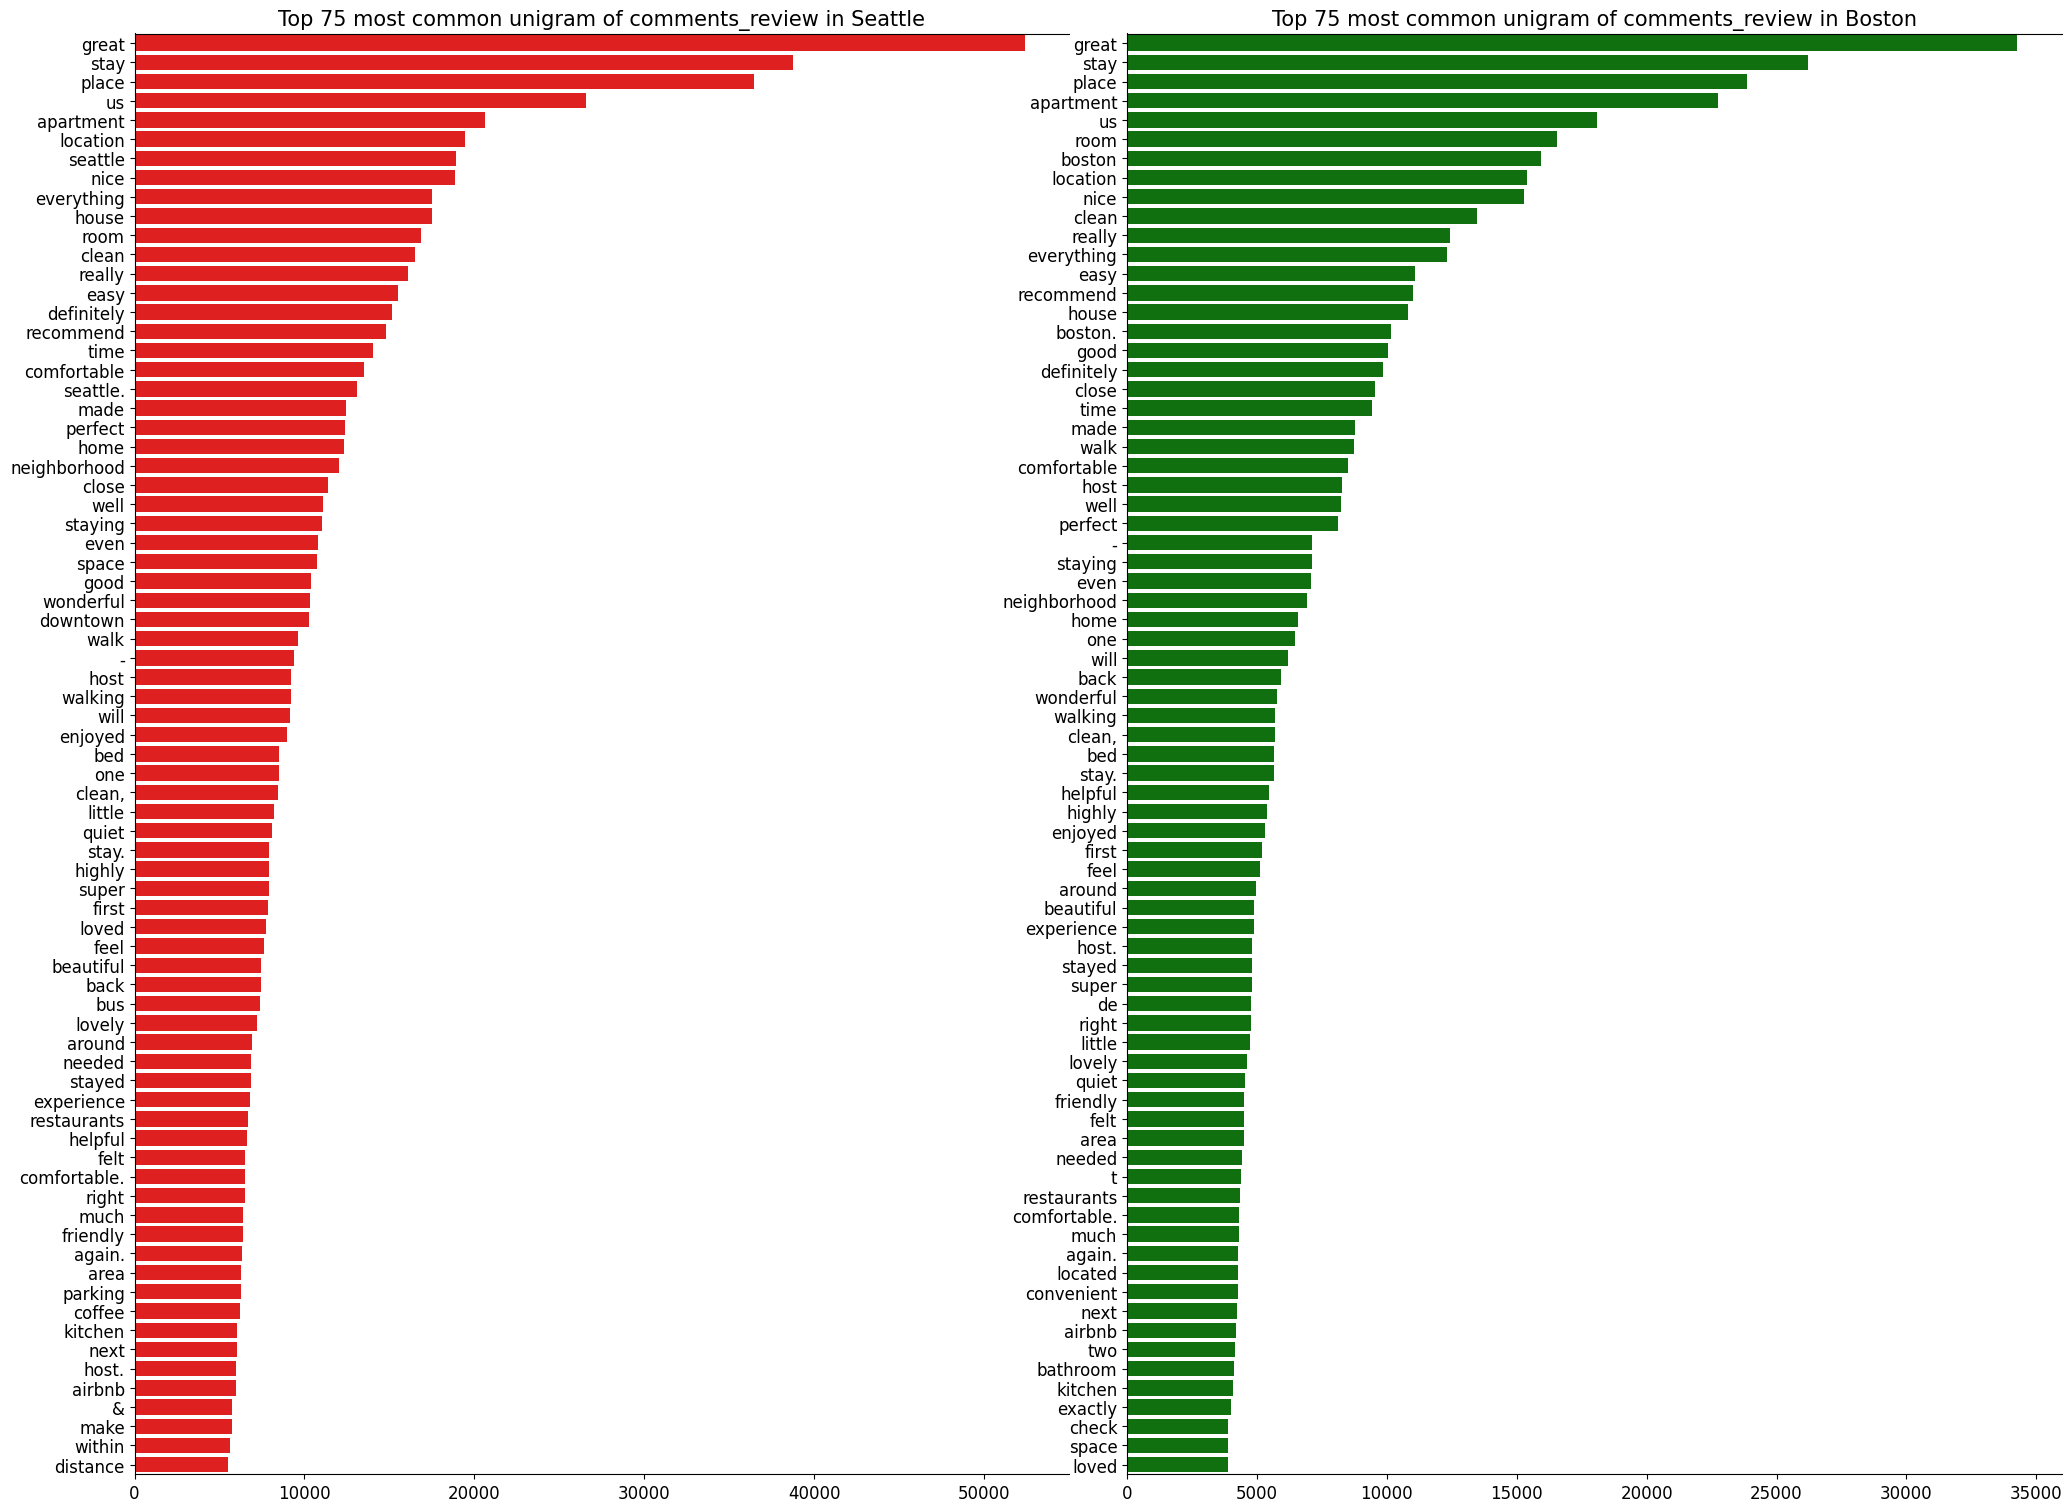

In [30]:
from wordcloud import STOPWORDS
from collections import defaultdict
import string

def ngrams_generative(text, n_grams = 1):
    
    """
    Description: list out the n_grams from the input text columns
    Input :
            text (string): your text column that you want to analyse
            n_grams (int): must be 1,2,3 - the n_grams type that you focus on
    Output: list of n_grams
    """
    
    token = [token for token in str(text).lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_grams)])
    return [' '.join(ngram) for ngram in ngrams]

def Ngram_topN(dataset, n_grams, top_N = 100):
    
    """
    Descriptions: display the top N_grams that you consider
    Input: 
            dataset (dataframe) that contains your considered text column
            n_grams (integer) : type of N_grams
            top_N (integer): number of the highest frequency of N_grams in your dataset
    """
    
    bos_ngrams = defaultdict(int)
    sea_ngrams = defaultdict(int)
    is_sea = dataset['city'] == 'seattle'
    for mes in dataset[is_sea]['comments']:
        for word in ngrams_generative(mes, n_grams):
            sea_ngrams[word] += 1
            
    for mes in dataset[~is_sea]['comments']:
        for word in ngrams_generative(mes, n_grams):
            bos_ngrams[word] += 1
    
    sea_ngrams = pd.DataFrame(sorted(sea_ngrams.items(), key = lambda x: x[1])[::-1])
    bos_ngrams = pd.DataFrame(sorted(bos_ngrams.items(), key = lambda x: x[1])[::-1])
    
    fig, ax = plt.subplots(ncols = 2, figsize = (20, (n_grams+1)*top_N // 10), dpi = 100)
    plt.tight_layout()
    sns.barplot(y = sea_ngrams[0].values[:top_N], x = sea_ngrams[1].values[:top_N], ax = ax[0], color = 'red')
    sns.barplot(y = bos_ngrams[0].values[:top_N], x = bos_ngrams[1].values[:top_N], ax = ax[1], color = 'green')
    
    for i in range(2):
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].tick_params(axis = 'x', labelsize = 12)
        ax[i].tick_params(axis = 'y', labelsize = 12)
    Ngram_used = {1:'unigram', 2:'bigrams', 3:'trigrams'}
    ax[0].set_title(f'Top {top_N} most common {Ngram_used[n_grams]} of comments_review in Seattle', fontsize = 15)
    ax[1].set_title(f'Top {top_N} most common {Ngram_used[n_grams]} of comments_review in Boston', fontsize = 15)
    
Ngram_topN(df_reviews, 1, 75)

How about the `Bi-grams` of the `comments`

>- Wow, the most 4 popular `bi-grams` in both cities is the same : `definitely stay`, `highly recommended`, `walking distance` and `stay again`

>- Almost the top 75-bigrams reflect the positive comments with the words like: `highly recommended`, `great location`, `great place`, `great host`, `great location`, `clean well`.

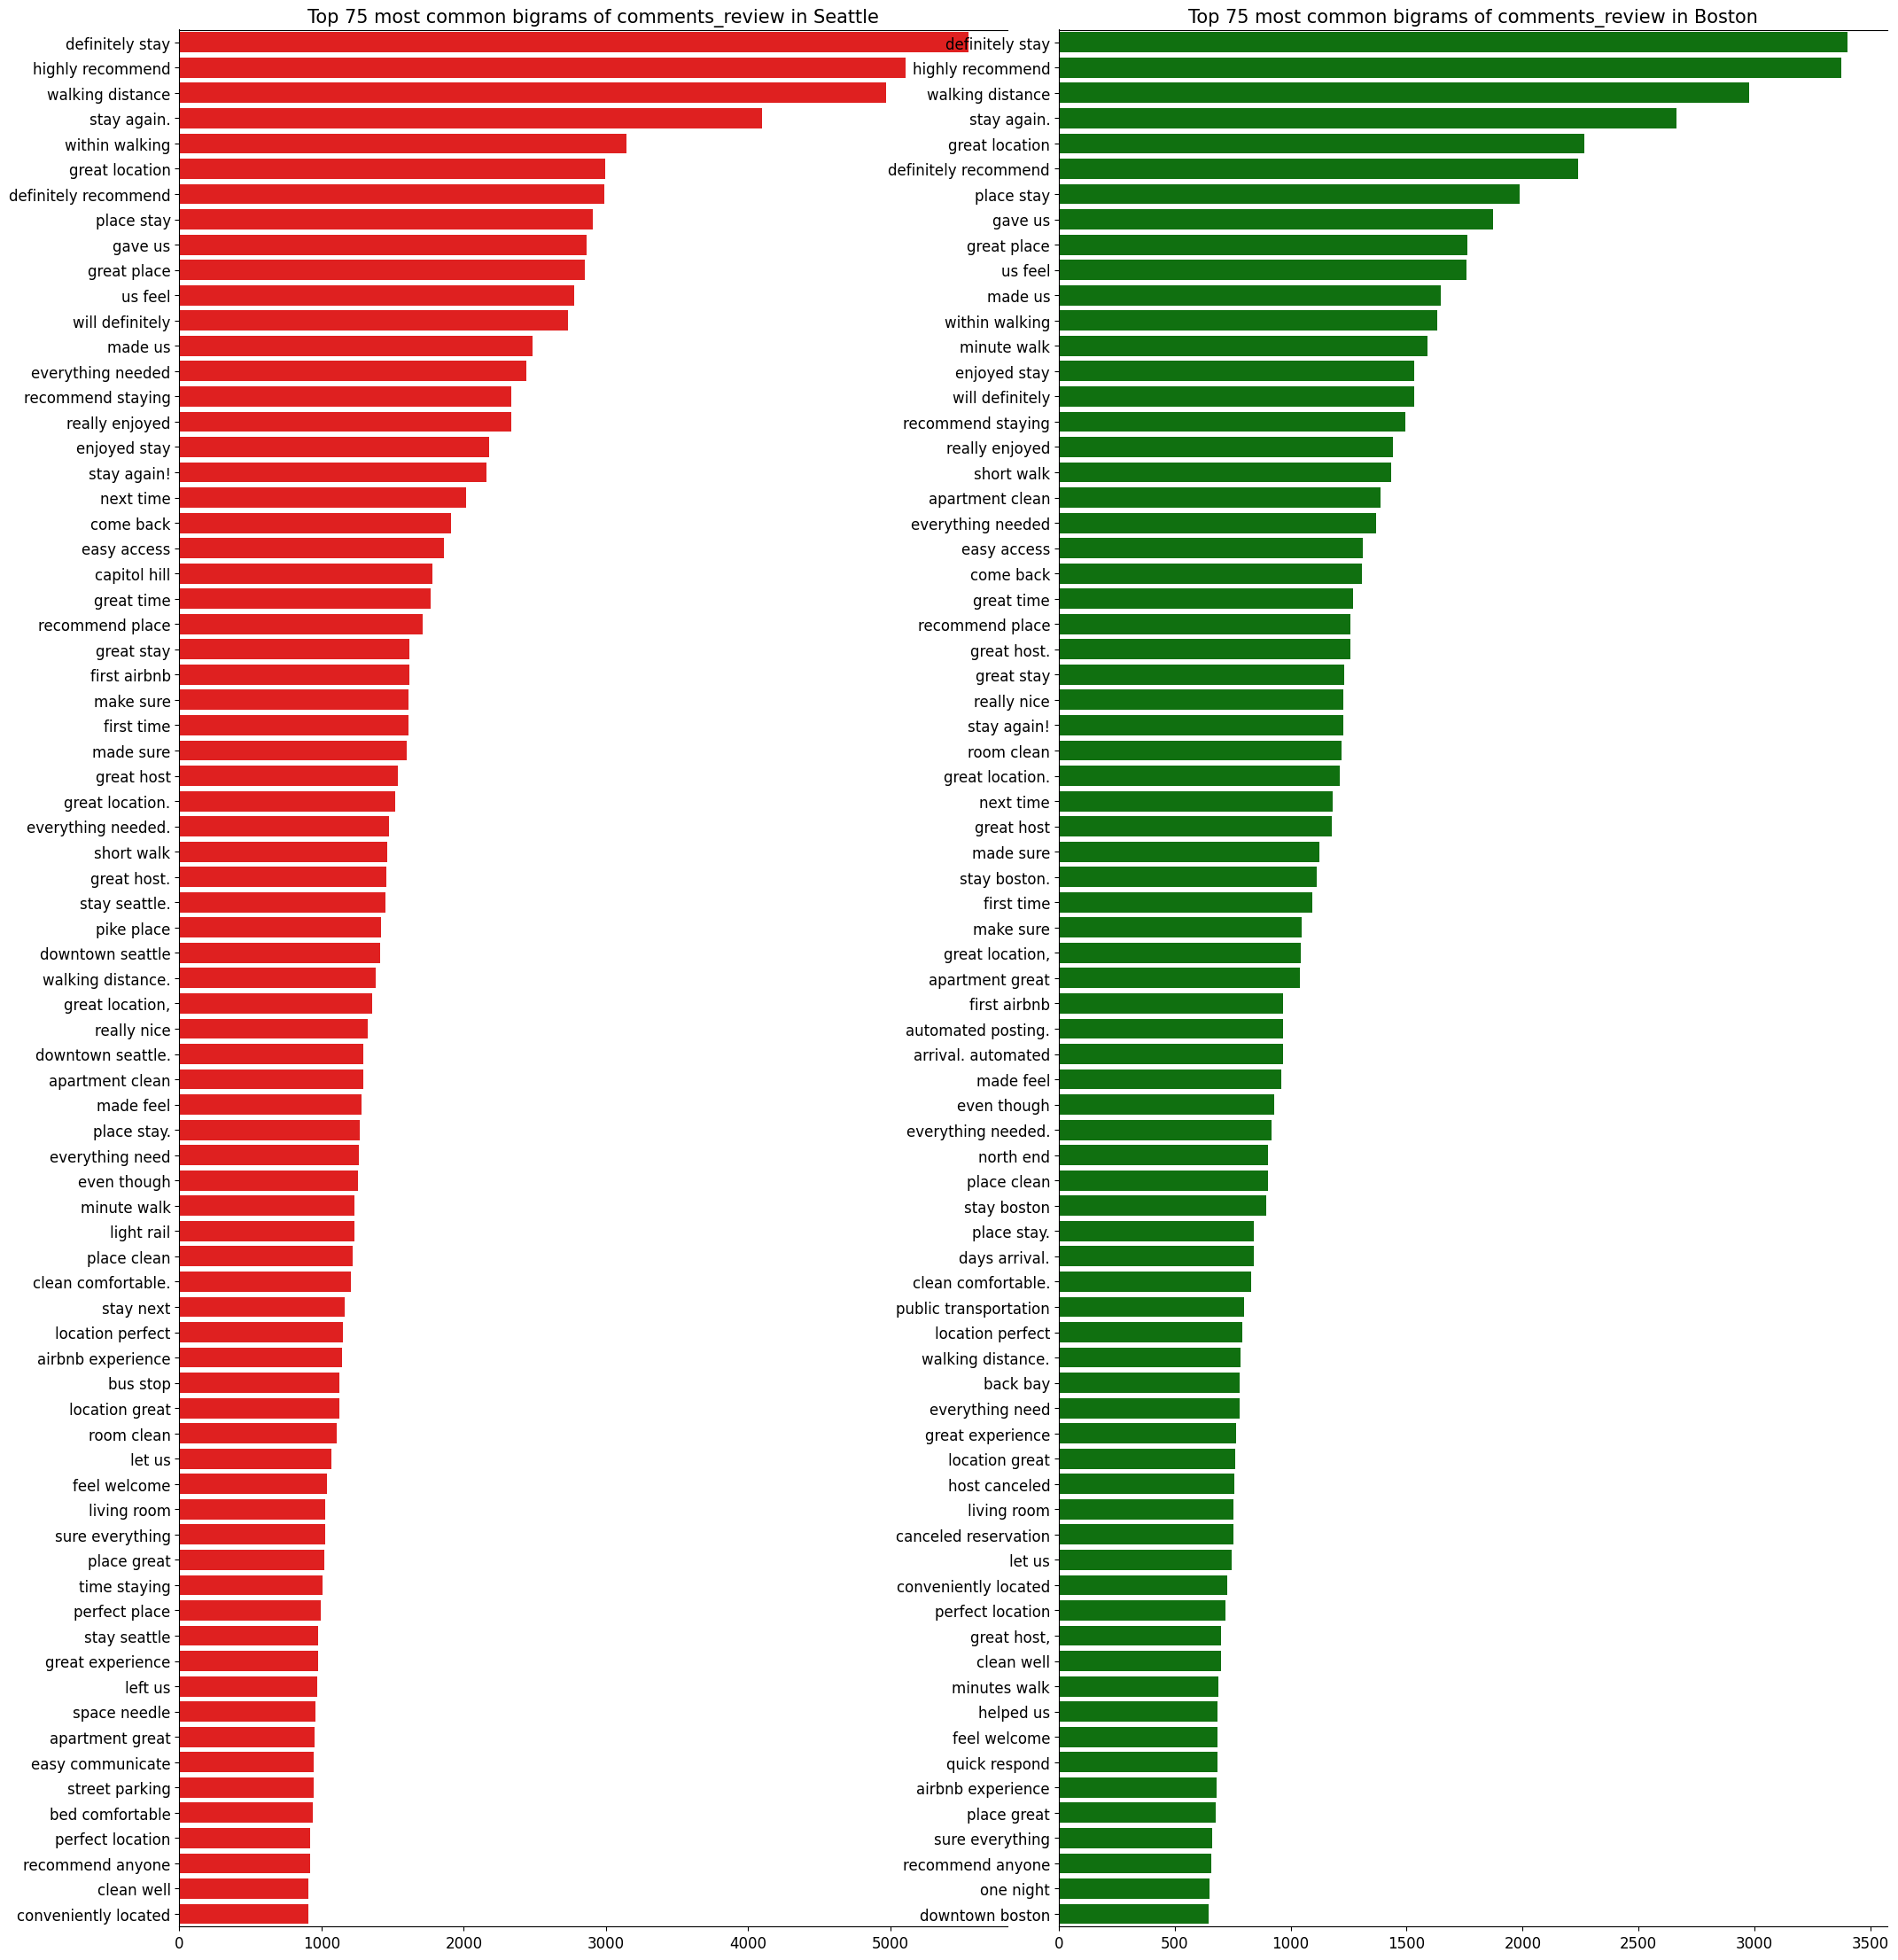

In [31]:
Ngram_topN(df_reviews, 2, 75)

How about the `Tri-grams` of the `comments`

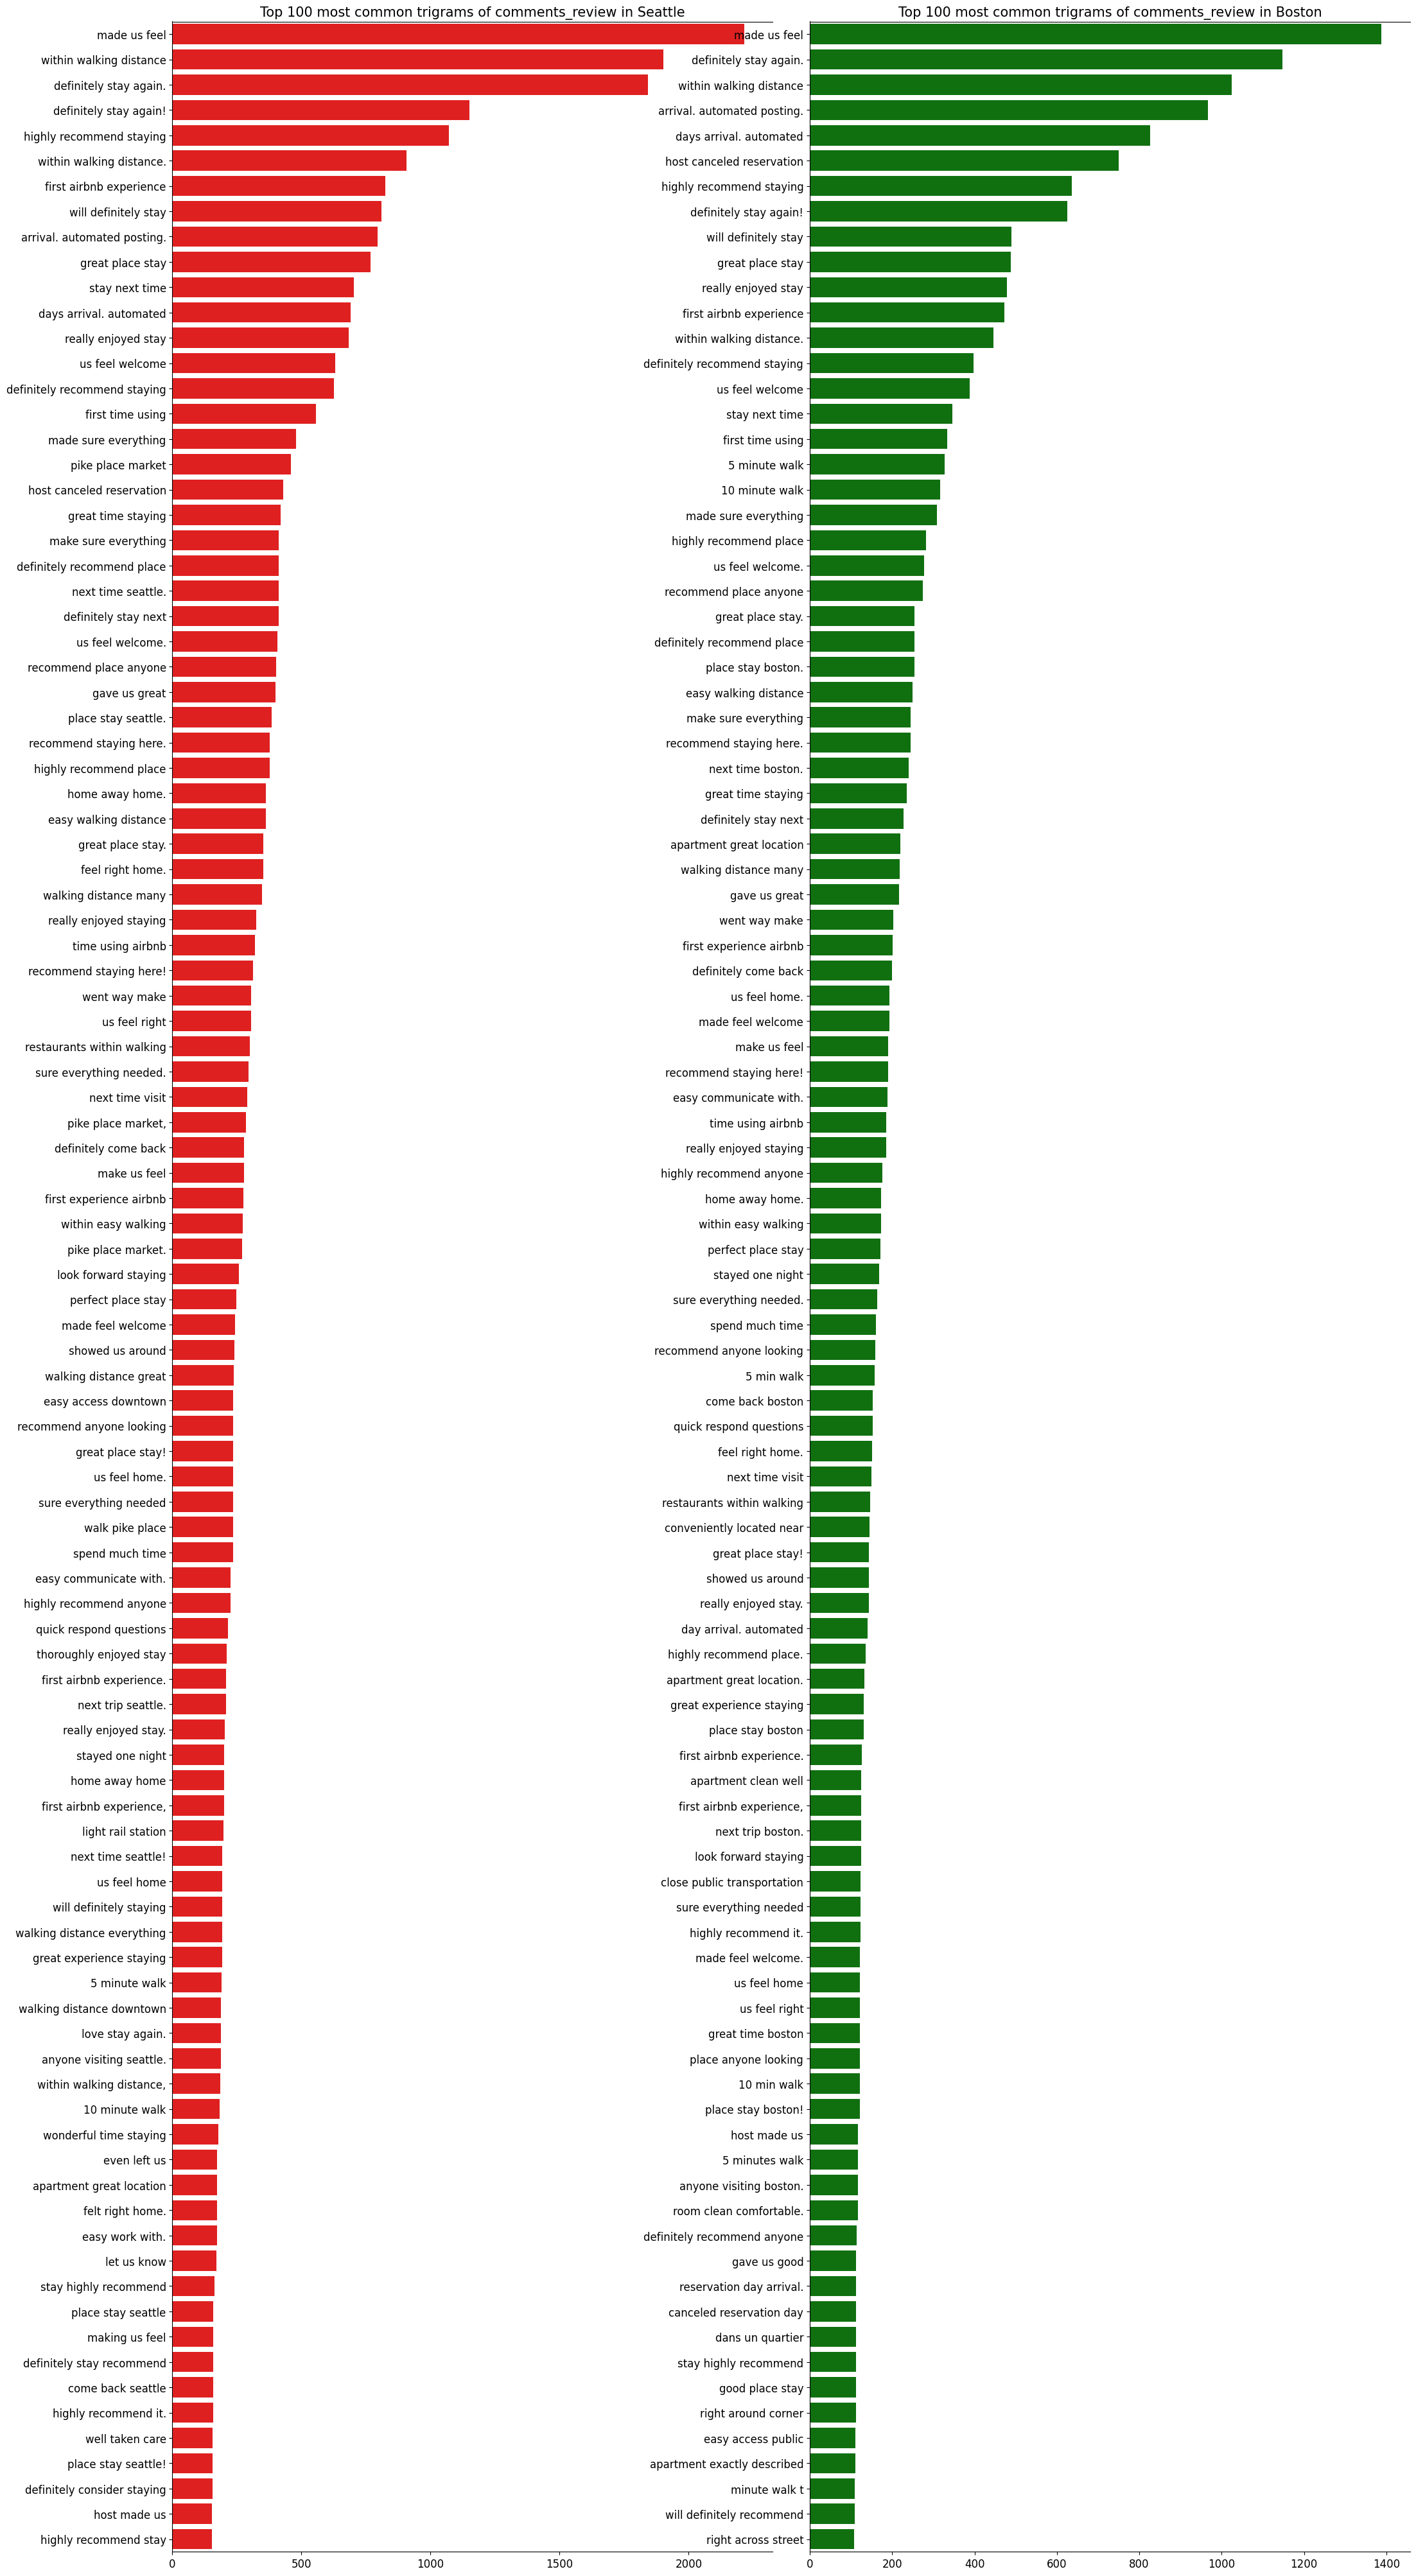

In [32]:
Ngram_topN(df_reviews, 3, 100)

=> From this, we can examine easier which words meant positve and negative in the `comments_reviews`.

# Q5. Make 2 time-series model to forecasting the difference of the reservation_prices between 2 cities

Our dataset is in 1 year only, we can make a ARIMA, SARIMA, SARIMAX model or something like this. 

But here, in this case, we can use a assumption of Markov properties: `the price of present is depended on the avg_price of the previous 3 days or 1 week` and I will use another Machine Learning models like `Random Forest regressor` and `Gradient Boosting`

#### Step 1. Making a rolling-window
Here, I let the `window_size = 3`

In [33]:
from statsmodels.tsa.arima_model import ARIMA

cities = ['boston', 'seattle']
df = calendar_df[calendar_df.city == cities[0]]
df['month'] = df['date'].dt.month
df = df.set_index('date')[['month', 'price']]
df = df.resample('D').mean()
window_size = 3
df['previous_roll_avg'] = df['price'].rolling(window_size, win_type='gaussian').mean(std=2)
df['previous_roll_std'] = df['price'].rolling(window_size).std()
df.head(10)

,month,price,previous_roll_avg,previous_roll_std
date,,,,
2016-09-06,9,241.043860,NaN,NaN
2016-09-07,9,251.833691,NaN,NaN
2016-09-08,9,251.748749,248.362814,6.205137
2016-09-09,9,261.859327,255.002830,5.812980
2016-09-10,9,266.847280,260.224350,7.692736
2016-09-11,9,249.565041,259.739353,8.894802
2016-09-12,9,245.732597,253.857782,11.248654
2016-09-13,9,250.206977,248.383867,2.419359
2016-09-14,9,256.647799,250.834602,5.487044


#### Step 2. Making a shifted-datetime

For a fixed `window_size = 3`, I will establish a model that based on the **3 previous days** for predicting the average_price today, so we must **shift** the rolling_window by 1 steps! Look at the following output

For example, we will forecast the price of `04 Jul 2017` based on the prices in `01 - 03, Jul 2017`

In [34]:
df[['previous_roll_avg', 'previous_roll_std']] = df[['previous_roll_avg', 'previous_roll_std']].shift(periods = 1)
df['previous k_days price'] = df['price'].shift(periods = window_size)
df.head(10)

,month,price,previous_roll_avg,previous_roll_std,previous k_days price
date,,,,,
2016-09-06,9,241.043860,NaN,NaN,NaN
2016-09-07,9,251.833691,NaN,NaN,NaN
2016-09-08,9,251.748749,NaN,NaN,NaN
2016-09-09,9,261.859327,248.362814,6.205137,241.043860
2016-09-10,9,266.847280,255.002830,5.812980,251.833691
2016-09-11,9,249.565041,260.224350,7.692736,251.748749
2016-09-12,9,245.732597,259.739353,8.894802,261.859327
2016-09-13,9,250.206977,253.857782,11.248654,266.847280
2016-09-14,9,256.647799,248.383867,2.419359,249.565041


#### Step 3. Replacing the missing_values by its averages

Here, we will replace the missing values (`NaN`) by the averages values at each column that contains missing values. 

But now, look at the relation between the `actual_price` and its average `previous-3-days_rolling_price` (with `3` is the size of our window function).

<AxesSubplot:xlabel='date'>

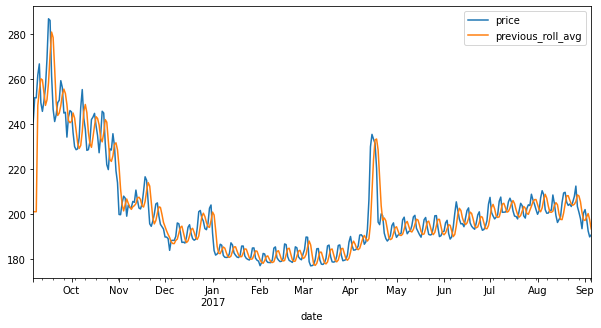

In [35]:
df = df.fillna(df.mean())
df[['price', 'previous_roll_avg']].plot(figsize = (10, 5))

#### Step 4. Making a model
Now, I create `Random Forest` to make a forecasting model!

0.8720093985919534

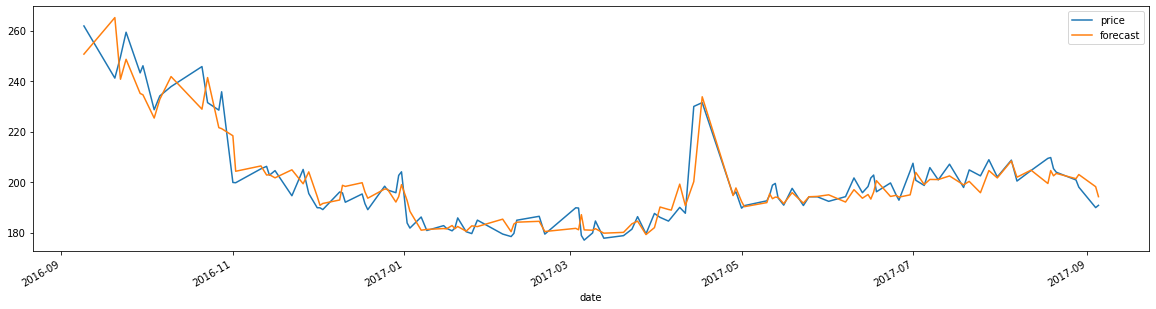

In [36]:
X = df.drop(columns = 'price')
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

clfs = [RandomForestRegressor(n_estimators = 200, max_depth=9,
                               criterion = 'mse',
                               n_jobs=-1), 
        GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.05, subsample=0.8,
                                  max_depth=7)]

clf = clfs[0]
clf.fit(X_train, y_train)

preds = y_test.reset_index()
preds['forecast'] = clf.predict(X_test)
preds.set_index('date').plot(figsize = (20, 5))
r2_score(y_test, clf.predict(X_test))

So, the `r2_score` is about 0.88 when using `Random forest regressor`

#### Wraping up together

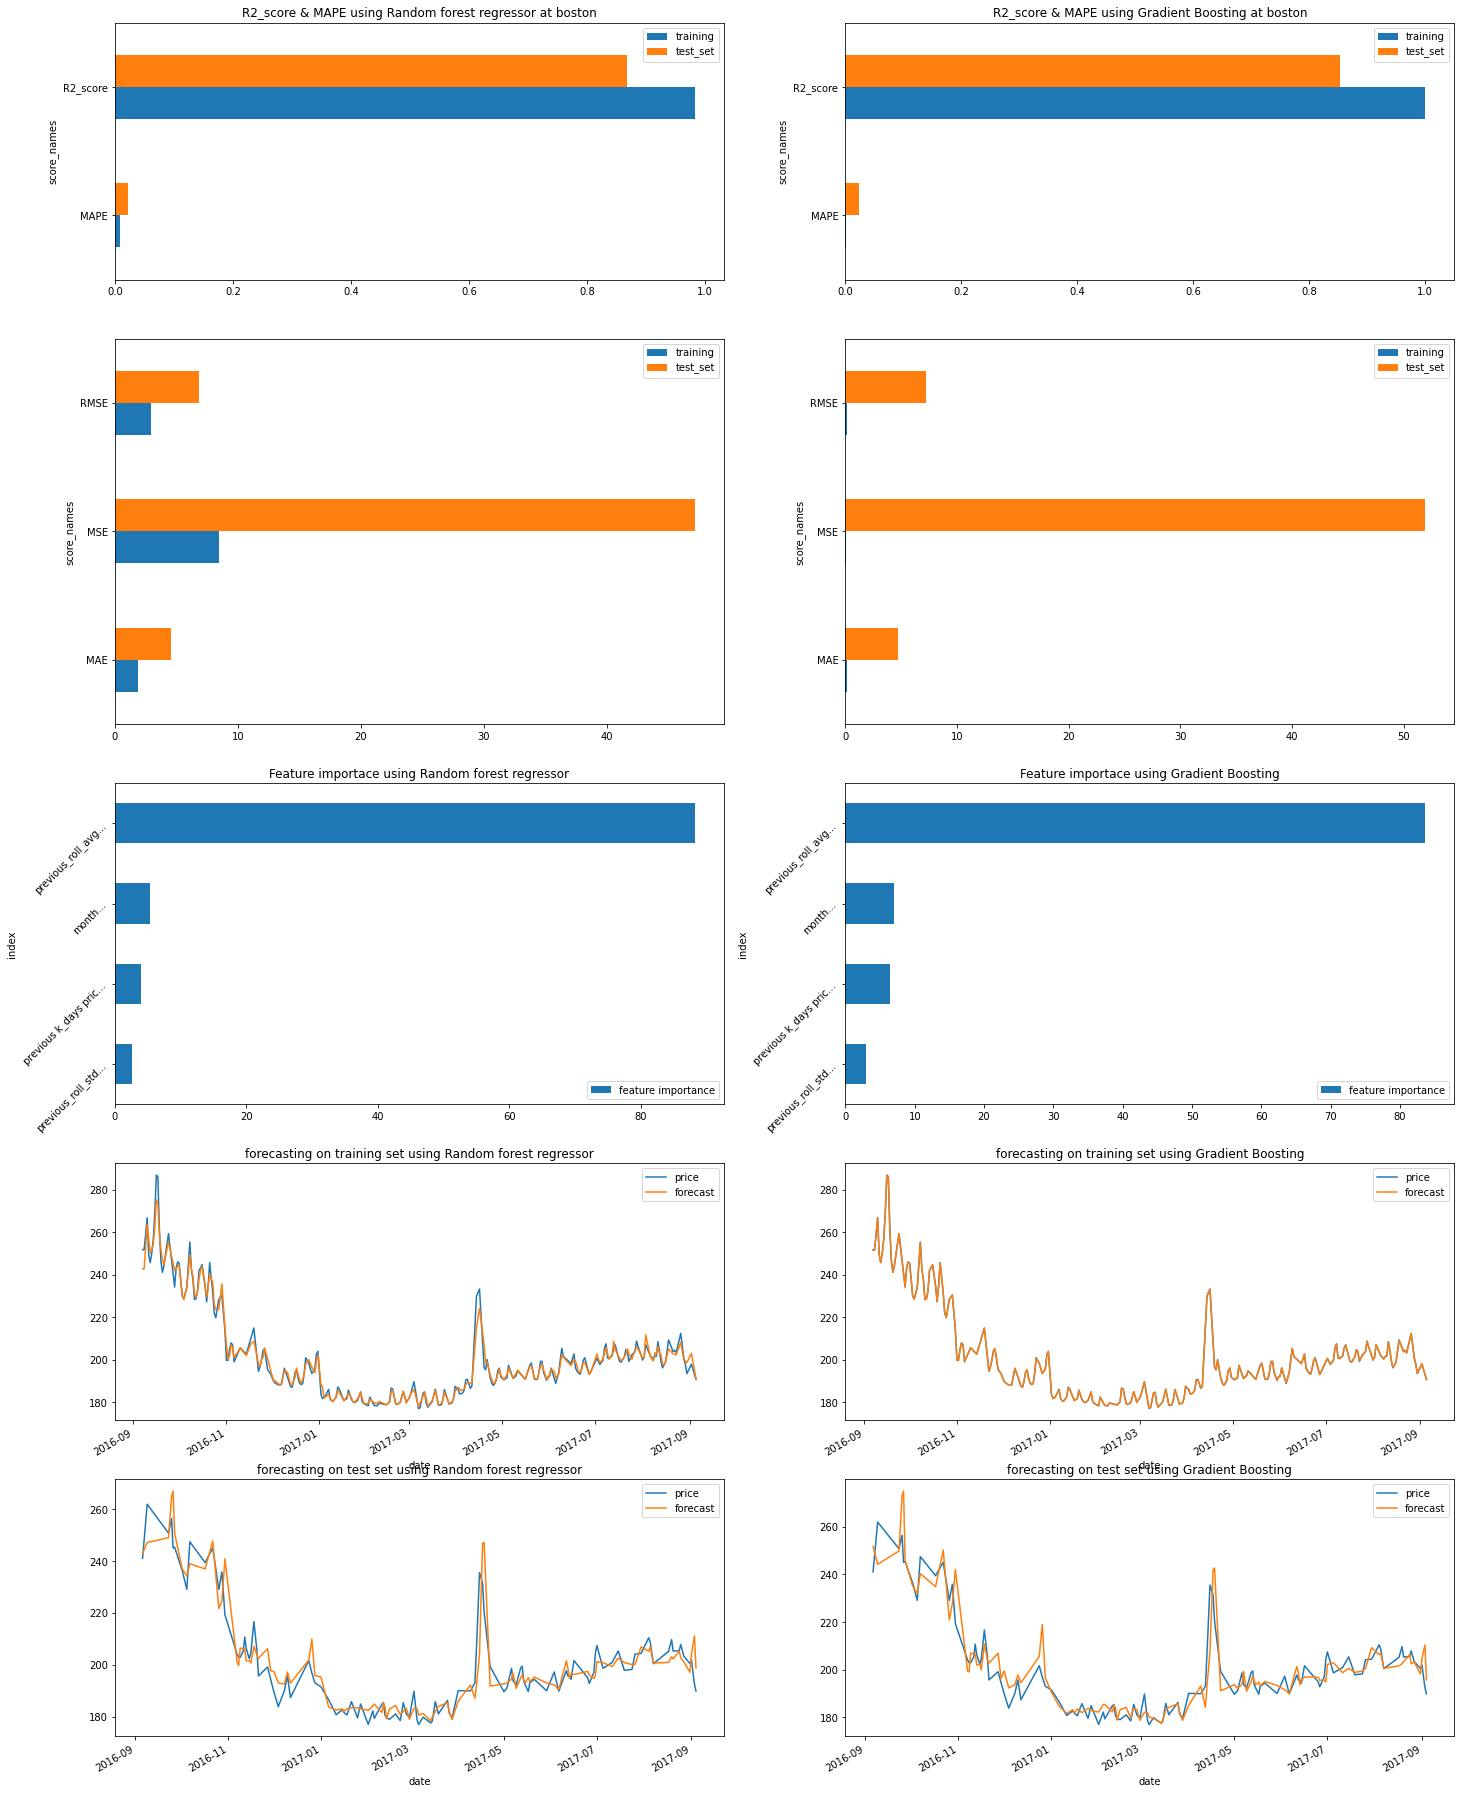

In [37]:
## input
window_size = 3
df = calendar_df[calendar_df.city == cities[1]]

## function : 

def display_timeseries(window_size, city):
    
    """
    Description: display the results of time-series forecasting based on the 2 algorithms
    Input: 
            window_size (integer): size of window function
            city (strings) : must be the names of the 2 considered cities in this topic: seattle and boston
    Output: display the results of the 2 difference algorithms (Random Forest & Gradient Boosting)
            - Score evaluated of MSE, MAPE, R2_score, MSE and RMSE
            - Feature importance
            - Time-series forecasting and its actual values on the training & test sets.
    """
    
    df = calendar_df[calendar_df.city == city]
    df['month'] = df['date'].dt.month
    df = df.set_index('date')[['month', 'price']]
    df = df.resample('D').mean()
    df['previous_roll_avg'] = df['price'].rolling(window_size, win_type='gaussian').mean(std=2)
    df['previous_roll_std'] = df['price'].rolling(window_size).std()
    df[['previous_roll_avg', 'previous_roll_std']] = df[['previous_roll_avg', 'previous_roll_std']].shift(periods = 1)
    df['previous k_days price'] = df['price'].shift(periods = window_size)
    df = df.fillna(df.mean())
    X = df.drop(columns = 'price')
    y = df.price
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

    clfs = [RandomForestRegressor(n_estimators = 200, max_depth=9,
                                   criterion = 'mse',
                                   n_jobs=-1), 
            GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.05, subsample=0.8,
                                      max_depth=7)]
    methods = ['Random forest regressor', 'Gradient Boosting']
    fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (24, 35), gridspec_kw = {'height_ratios': [2, 3, 2.5, 2, 2]})
    ax = ax.ravel()
    for k, model in enumerate(clfs):
        model.fit(X_train, y_train)
        feature_importance = 100*model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        dat = pd.DataFrame({'index': list( x[:20]+'...' for x in X_train.columns[sorted_idx]),
                                'feature importance': feature_importance[sorted_idx]
                               })
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)    

        # plot
        scor = pd.DataFrame({'score_names': ['MAPE', 'R2_score'],
                                'training': [mape(y_train, train_pred), r2_score(y_train, train_pred)],
                                'test_set': [mape(y_test, test_pred), r2_score(y_test, test_pred)]                        
                               }).set_index('score_names')
        scor.plot(ax = ax[k], title = 'R2_score & MAPE using ' + methods[k] + ' at ' + city, kind = 'barh')

        err = pd.DataFrame({'score_names': ['MAE', 'MSE', 'RMSE'],
                                'training': [mae(y_train, train_pred), mse(y_train, train_pred), np.sqrt(mse(y_train, train_pred))],
                                'test_set': [mae(y_test, test_pred), mse(y_test, test_pred), np.sqrt(mse(y_test, test_pred))]                        
                               }).set_index('score_names').plot(ax = ax[k + 2], kind = 'barh')

        dat.set_index('index').plot(ax = ax[k + 4], rot = 45, title = 'Feature importace using ' + methods[k], kind = 'barh')

        preds = y_train.reset_index()
        preds['forecast'] = model.predict(X_train)
        preds.set_index('date').plot(ax = ax[k + 6], title = 'forecasting on training set using ' + methods[k])

        preds = y_test.reset_index()
        preds['forecast'] = model.predict(X_test)
        preds.set_index('date').plot(ax = ax[k + 8], title = 'forecasting on test set using ' + methods[k])   
        
display_timeseries(3, city = cities[0])

Yeah! Our forecasting model is pretty good in `Seattle` when the `R2_score` is over 0.85 and the `MAPE` is lower than 0.02. And how about in `Boston`?

>> In the training set, the model is nearly concided when using `Gradient Boosting` but the `R2_score` on the `test_set` when using `Random Forest` is better!!

>> The `MAE < 8` on both model showed that our algorithms is right (noting that the average_price at Seattle is over `180$`

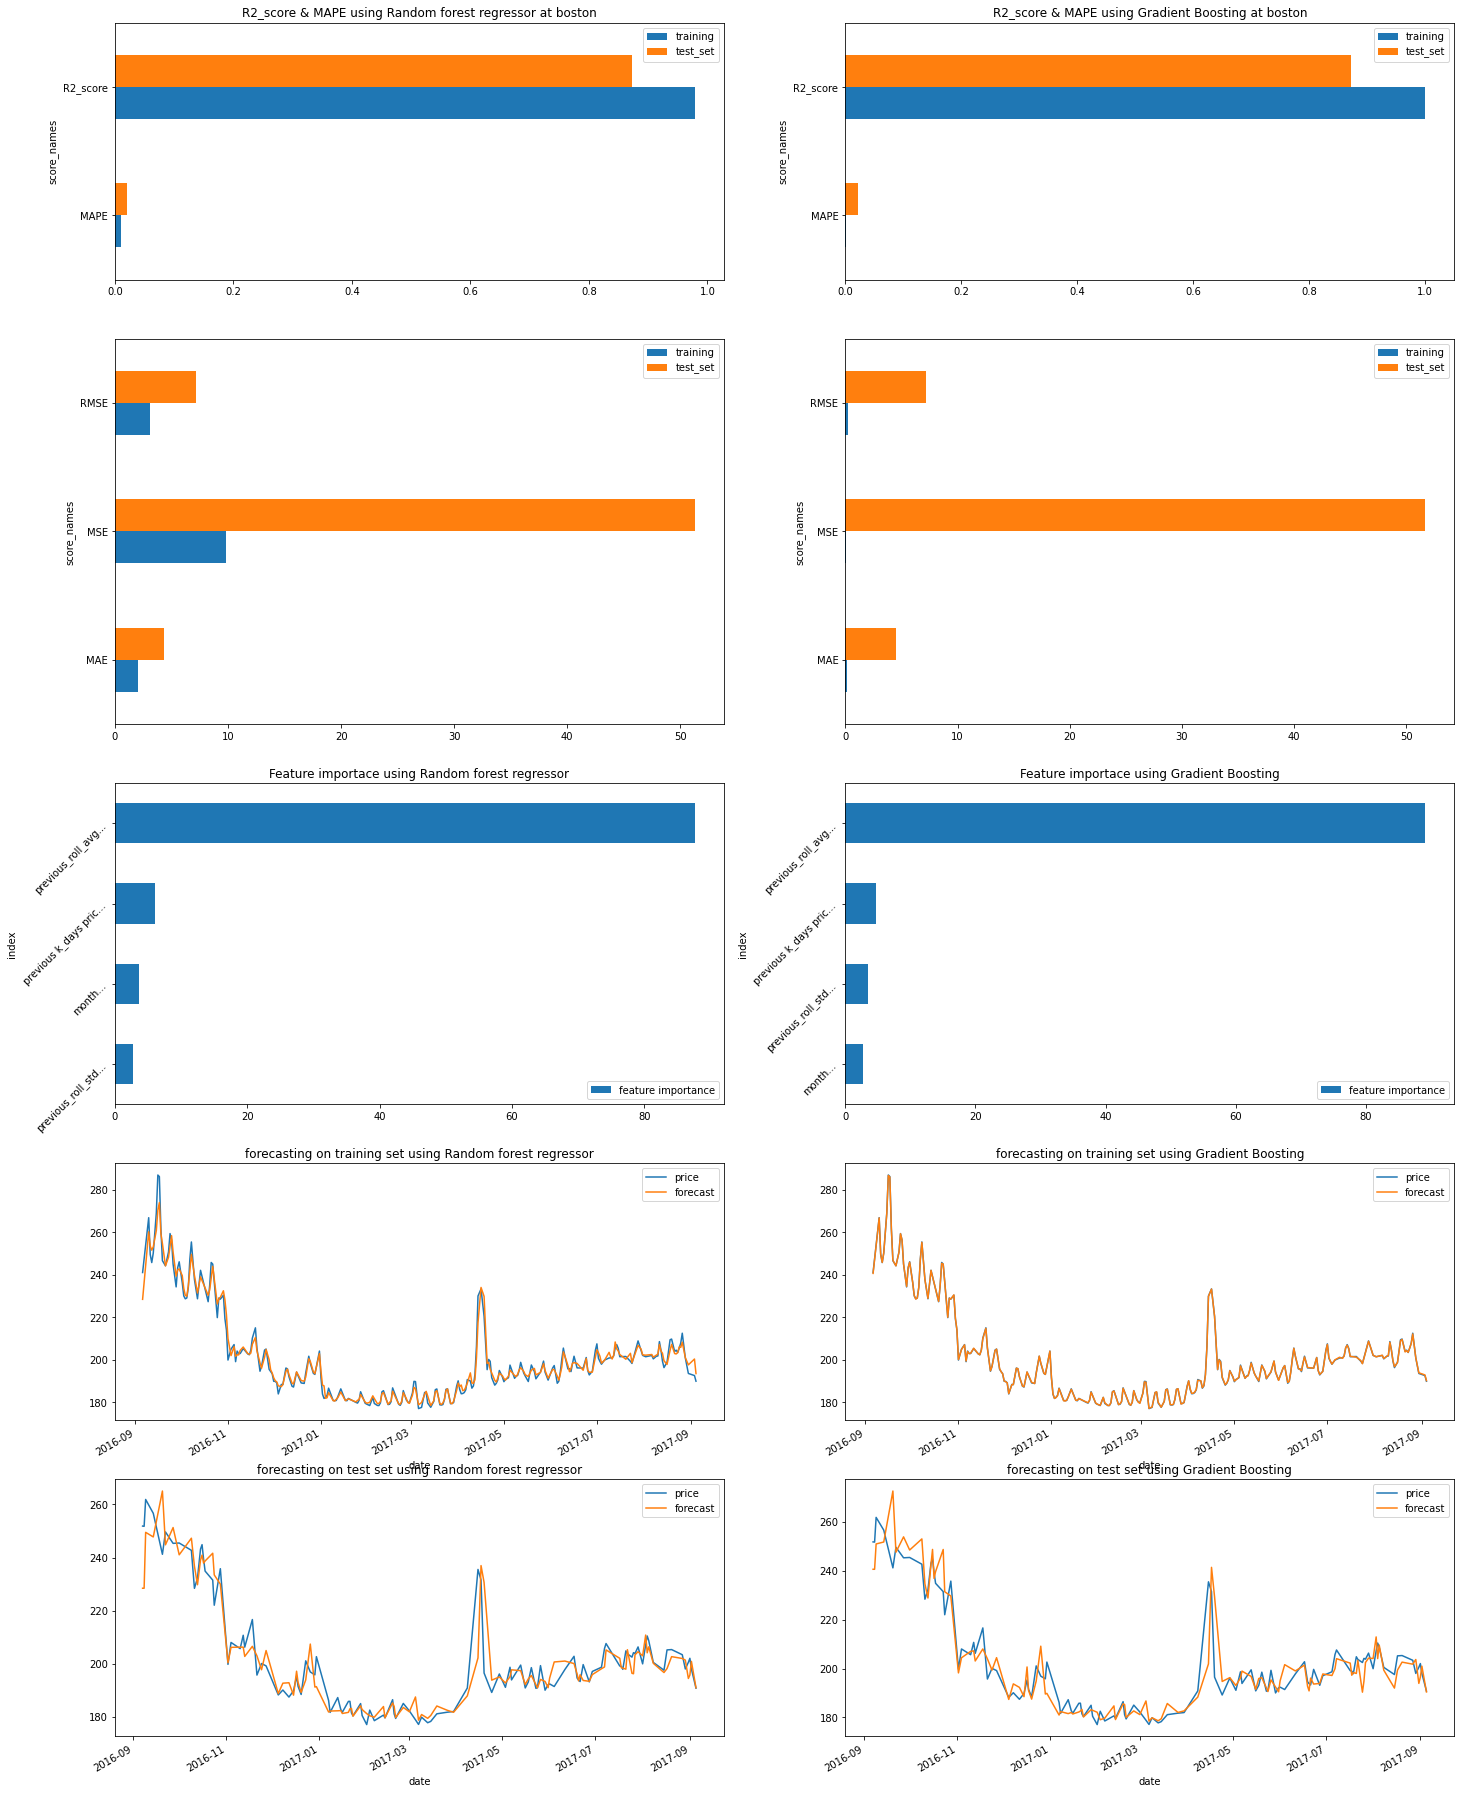

In [38]:
display_timeseries(3, city = cities[0])

### Issues!

>- I haven't used the `Grid-search CV / Hyper tuning parameters` to improve the forecasting model in Question 3 and Question 5.

>- My solution at question 3 is also not good at all, there is an overfiting problem here!

>- The model selection was not optimized since I haven't droped the weak-corelated features in Question 3.

[Github Repo](https://github.com/Nhan121/Udacity_stage1_Due_02_Aug)